In [1]:
using Arpack
using LinearAlgebra
using CairoMakie
using LaTeXStrings
using Statistics

In [2]:
function delta_F(V0, kF)
    return -(V0/3) * pi * kF^2
end

delta_F (generic function with 1 method)

In [3]:
function alpha_F(V0, kF, kappa, n, a)
    return (V0 * sqrt(3) * im * a * n * kappa^2 * kF^2) / (8 * (1 + kappa^2))
end

alpha_F (generic function with 1 method)

In [4]:
function H_F(V0, kF, kappa, n, a, omega, q, theta)
    delt = delta_F(V0, kF)
    mat0 = [0 delt conj(delt); 
            conj(delt) 0 delt; 
            delt conj(delt) 0]
    alph = alpha_F(V0, kF, kappa, n, a)
    qq = q * cos(theta) + im * q * sin(theta)
    mat1 = [0 alph * (omega * qq + conj(omega) * conj(qq)) conj(alph) * (omega^2 * qq + conj(omega^2) * conj(qq));
             conj(alph) * (omega * qq + conj(omega) * conj(qq)) 0 alph * (qq + conj(qq));
             alph * (omega^2 * qq + conj(omega^2) * conj(qq)) conj(alph) * (qq + conj(qq)) 0]
    return mat0 + mat1
end

H_F (generic function with 1 method)

In [5]:
function delta_H(Vg, kF, kappa, n)
    return (Vg / 3) * (pi * kF^2 / (1 + kappa^2)^2) * (1 + kappa^2 * exp(im * n * 2 * pi / 3)) * (1 + kappa^2 * exp(-im * n * 2 * pi / 3))
end

delta_H (generic function with 1 method)

In [6]:
function alpha_H(Vg, kF, kappa, n, a)
    return -(Vg / 3) * (pi * kF^2 / (8 * (1 + kappa^2)^3)) * (1 + kappa^2 * exp(im * n * 2 * pi / 3)) * 
    (4 * pi * kappa * (exp(im * n * 2 * pi / 3) - 1) - 3 * sqrt(3) * im * a * n * kappa^2 * (1 + kappa^2))
end

alpha_H (generic function with 1 method)

In [7]:
function H_H(Vg, kF, kappa, n, a, omega, q, theta)
    delt = delta_H(Vg, kF, kappa, n)
    mat0 = [0 delt conj(delt); 
            conj(delt) 0 delt; 
            delt conj(delt) 0]
    alph = alpha_H(Vg, kF, kappa, n, a)
    qq = q * cos(theta) + im * q * sin(theta)
    mat1 = [0 alph * (omega * qq + conj(omega) * conj(qq)) conj(alph) * (omega^2 * qq + conj(omega^2) * conj(qq));
             conj(alph) * (omega * qq + conj(omega) * conj(qq)) 0 alph * (qq + conj(qq));
             alph * (omega^2 * qq + conj(omega^2) * conj(qq)) conj(alph) * (qq + conj(qq)) 0]
    return mat0 + mat1
end

H_H (generic function with 1 method)

In [8]:
function H0(V0, Vg, kF, kappa, n)
    delt = delta_H(Vg, kF, kappa, n) + delta_F(V0, kF)
    mat0 = [0 delt conj(delt); 
            conj(delt) 0 delt; 
            delt conj(delt) 0]
    return mat0
end

H0 (generic function with 1 method)

In [9]:
function H_k(vF, q, theta)
    n1 = [cos(0), sin(0)]
    n3 = [cos(2 * pi / 3), sin(2 * pi / 3)]
    n5 = [cos(4 * pi / 3), sin(4 * pi / 3)]
    k = vF * q * [cos(theta), sin(theta)]
    return [dot(k, n1) 0 0; 0 dot(k, n3) 0; 0 0 dot(k, n5)]
end

H_k (generic function with 1 method)

In [10]:
# useful phase
omega = exp(im * 2 * pi / 3)

-0.4999999999999998 + 0.8660254037844387im

<font size="12">Fock (ED) 3-Comp</font>

In [11]:
# parameters
a = 1
kappa = 4 * pi / (3 * a)
kF = (1e-10) * kappa
V0 = 1
# small deviation from high-symmetry point
q = 10^(-1) * kF
num_pts = Int(1e2)

100

In [12]:
F_overlaps = zeros(ComplexF64, num_pts)
n_list = range(1, 10^13, num_pts)

1.0:1.0101010101009091e11:1.0e13

In [13]:
for j in 1:num_pts
    n = n_list[j]
    thetas = [0, pi/3, 2*pi/3, pi, 4*pi/3, 5*pi/3]
    states = zeros(ComplexF64, (length(thetas), 3))
    for i in 1:length(thetas)
        theta = thetas[i]
        ham = H_F(V0, kF, kappa, n, a, omega, q, theta)
        gs = eigvecs(Hermitian(ham))[:, 1]
        states[i, :] = normalize(gs)
    end
    pancharatnam = dot(states[1, :], states[2, :]) * dot(states[2, :], states[3, :]) * dot(states[3, :], states[1, :]) / 
    (abs(dot(states[1, :], states[2, :])) * abs(dot(states[2, :], states[3, :])) * abs(dot(states[3, :], states[1, :])))
    F_overlaps[j] = pancharatnam
end

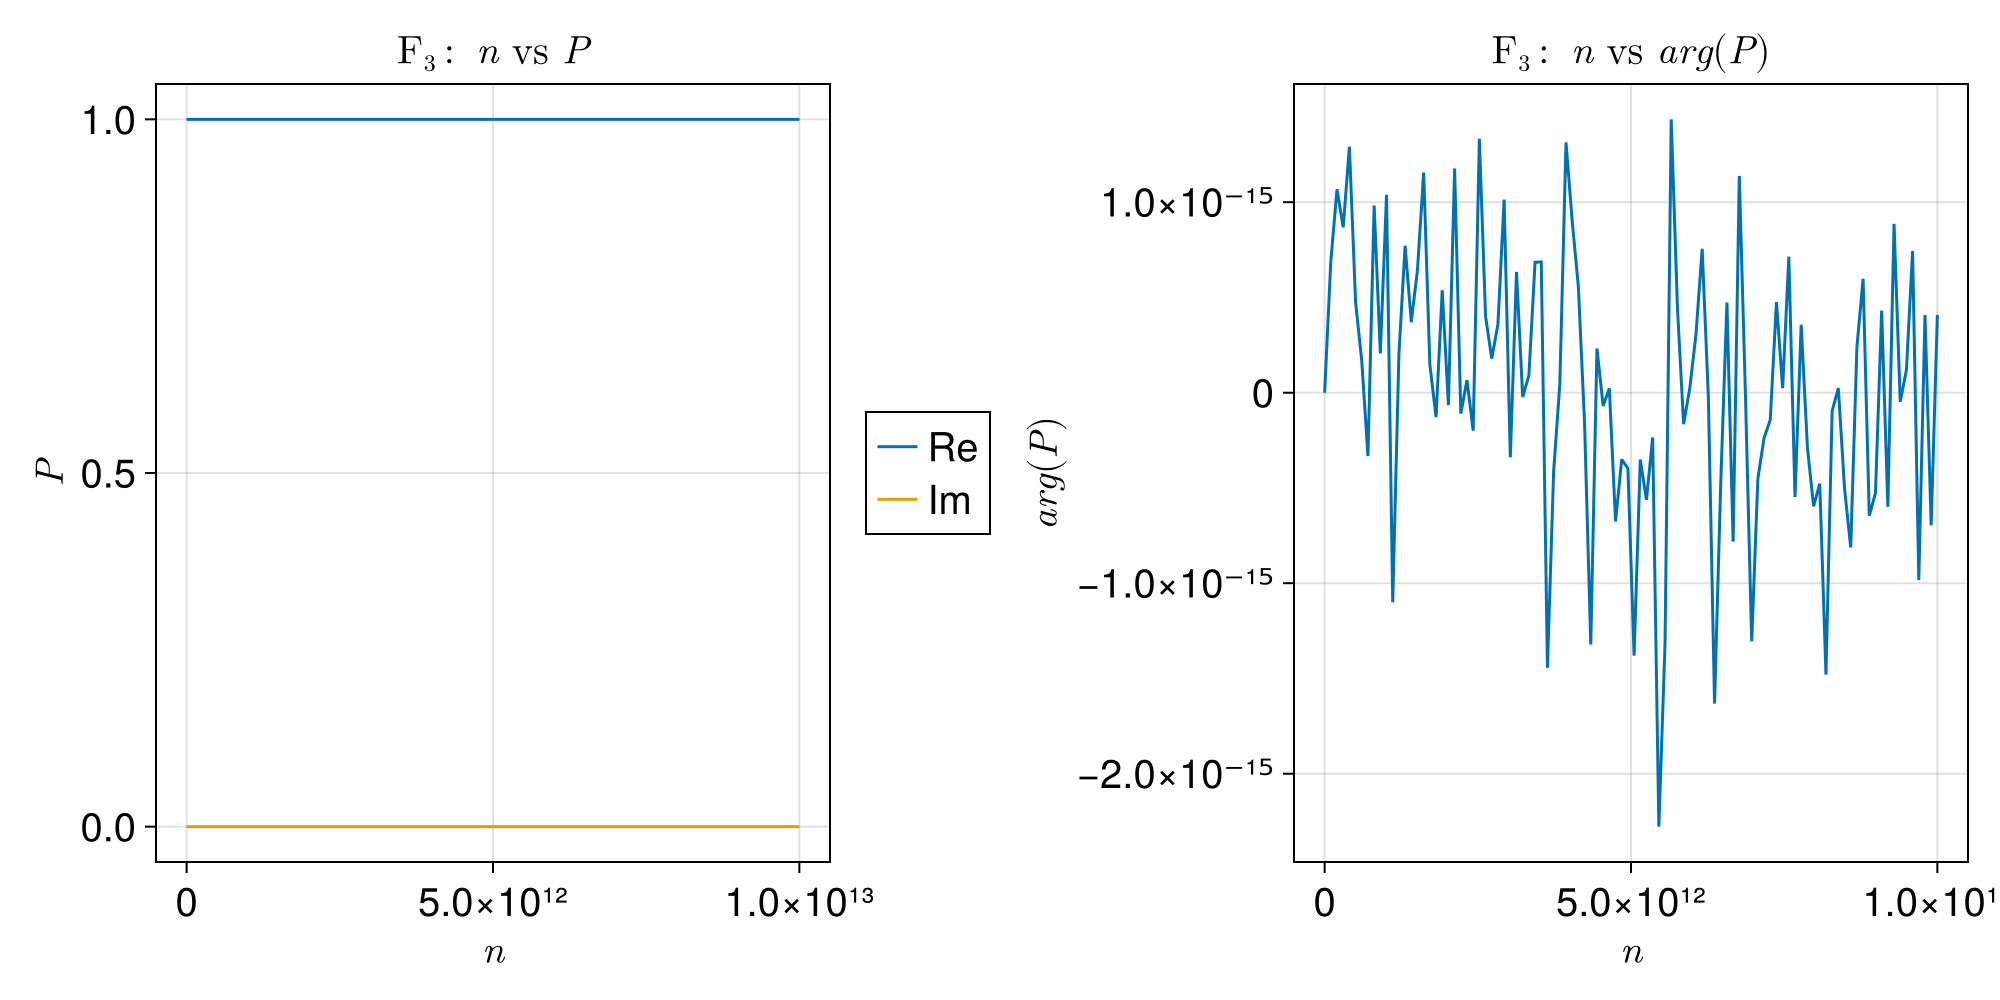

In [14]:
# create plot
P = Figure(size=(1000, 500), fontsize=20)
# create and configure axes
ax = Axis(P[1, 1], title = L"\text{F_3: } n \text{ vs } P", xlabel = L"n", ylabel = L"P")
lines!(ax, n_list, real(F_overlaps), label = "Re")
lines!(ax, n_list, imag(F_overlaps), label = "Im")
P[1, 2] = Legend(P, ax, framevisible = true)
ax_theta = Axis(P[1, 3], title = L"\text{F_3: } n \text{ vs } arg(P)", xlabel = L"n", ylabel = L"arg(P)")
lines!(ax_theta, n_list, angle.(F_overlaps))
P

<font size="12">Hartree (ED) 3-Comp</font>

In [15]:
# parameters
a = 1
kappa = 4 * pi / (3 * a)
kF = (1e-10) * kappa
Vg = 1
# small deviation from high-symmetry point
q = 10^(-1) * kF
num_pts = Int(1e2)

100

In [16]:
H_overlaps = zeros(ComplexF64, num_pts)
n_list = range(1, 10^13, num_pts)

1.0:1.0101010101009091e11:1.0e13

In [17]:
for j in 1:num_pts
    n = n_list[j]
    thetas = [0, pi/3, 2*pi/3, pi, 4*pi/3, 5*pi/3]
    states = zeros(ComplexF64, (length(thetas), 3))
    for i in 1:length(thetas)
        theta = thetas[i]
        ham = H_H(Vg, kF, kappa, n, a, omega, q, theta)
        gs = eigvecs(Hermitian(ham))[:, 1]
        states[i, :] = normalize(gs)
    end
    pancharatnam = dot(states[1, :], states[2, :]) * dot(states[2, :], states[3, :]) * dot(states[3, :], states[1, :]) / 
    (abs(dot(states[1, :], states[2, :])) * abs(dot(states[2, :], states[3, :])) * abs(dot(states[3, :], states[1, :])))
    H_overlaps[j] = pancharatnam
end

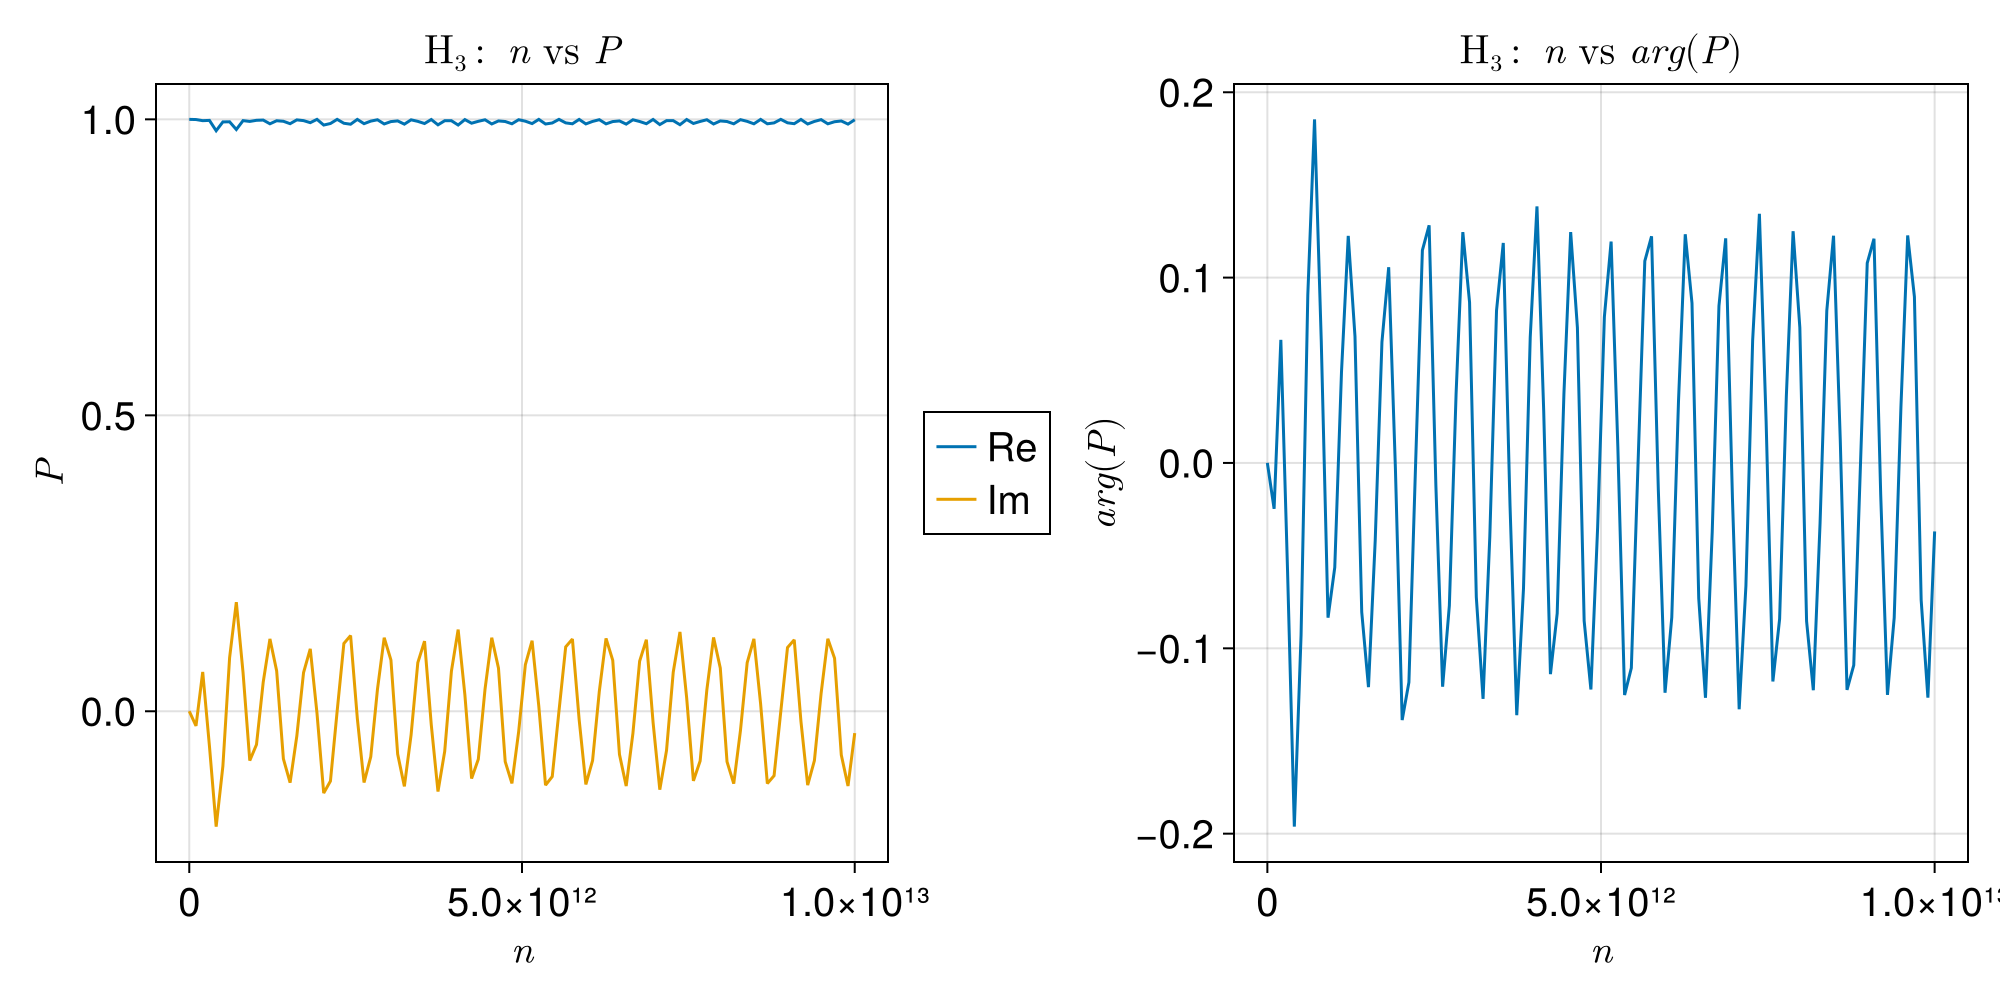

In [18]:
# create plot
P = Figure(size=(1000, 500), fontsize=20)
# create and configure axes
ax = Axis(P[1, 1], title = L"\text{H_3: } n \text{ vs } P", xlabel = L"n", ylabel = L"P")
lines!(ax, n_list, real(H_overlaps), label = "Re")
lines!(ax, n_list, imag(H_overlaps), label = "Im")
P[1, 2] = Legend(P, ax, framevisible = true)
ax_theta = Axis(P[1, 3], title = L"\text{H_3: } n \text{ vs } arg(P)", xlabel = L"n", ylabel = L"arg(P)")
lines!(ax_theta, n_list, angle.(H_overlaps))
P

<font size="12"> ED 6-Comp</font>

In [19]:
function ff_13(kappa, a, n, q2, q1, theta2, theta1)
    term1 = 8 * pi * (4 * pi * (1 + kappa^2)^2 * (1 + exp(2im * n * pi / 3) * kappa^2) + 
                     (kappa + kappa^3) * (4 * (-1 + exp(2im * n * pi / 3)) * pi * cos(theta2) - 
                     3 * im * a * exp(2im * n * pi / 3) * n * (kappa + kappa^3) * sin(theta2)) * q2)
                     
    term2 = 4 * pi * (8 * pi * kappa * (1 + kappa^2) * sin(pi / 6 - theta1) - 
                     im * exp(2im * n * pi / 3) * (kappa + kappa^3) * (-8im * pi * sin(pi / 6 - theta1) + 
                     3 * a * n * (kappa + kappa^3) * (sqrt(3) * cos(theta1) + sin(theta1))))
                     
    term3 = -32 * pi^2 * kappa^2 * cos(theta2) * sin(pi / 6 - theta1) - 
            exp(2im * n * pi / 3) * (-8im * pi * sin(pi / 6 - theta1) + 
            3 * a * n * (kappa + kappa^3) * (sqrt(3) * cos(theta1) + sin(theta1))) * 
            (4im * pi * cos(theta2) + 3 * a * n * (kappa + kappa^3) * sin(theta2)) * q2

    return (1 / (32 * pi^2 * (1 + kappa^2)^3)) * (term1 + term2 * q1 + term3 * q1 * q2)
end

ff_13 (generic function with 1 method)

In [20]:
function ff_15(kappa, a, n, q2, q1, theta2, theta1)
    term1 = 8 * pi * (4 * pi * (1 + kappa^2)^2 * (1 + exp(4im * n * pi / 3) * kappa^2) + 
                     (kappa + kappa^3) * (4 * (-1 + exp(4im * n * pi / 3)) * pi * cos(theta2) - 
                     3 * im * a * exp(4im * n * pi / 3) * n * (kappa + kappa^3) * sin(theta2)) * q2)
                     
    term2 = 4 * pi * (8 * pi * kappa * (1 + kappa^2) * sin(pi / 6 + theta1) + 
                     im * exp(4im * n * pi / 3) * (kappa + kappa^3) * (3 * a * n * (kappa + kappa^3) * 
                     (sqrt(3) * cos(theta1) - sin(theta1)) + 8im * pi * sin(pi / 6 + theta1)))
                     
    term3 = -32 * pi^2 * kappa^2 * cos(theta2) * sin(pi / 6 + theta1) + 
            exp(4im * n * pi / 3) * (3 * a * n * (kappa + kappa^3) * (sqrt(3) * cos(theta1) - sin(theta1)) + 
            8im * pi * sin(pi / 6 + theta1)) * (4im * pi * cos(theta2) + 3 * a * n * (kappa + kappa^3) * sin(theta2)) * q2

    return (1 / (32 * pi^2 * (1 + kappa^2)^3)) * (term1 + term2 * q1 + term3 * q1 * q2)
end

ff_15 (generic function with 1 method)

In [21]:
# function ff_35(kappa, a, n, q2, q1, theta2, theta1)
#     term1 = 64 * (1 + kappa^2)^2 * (1 + exp(2im * n * π / 3) * kappa^2) + 
#             64 * ((kappa + kappa^3) * sin(π / 6 + theta1) * q1 + 
#                   kappa * sin(π / 6 - theta2) * (1 + kappa^2 + 
#                   kappa * sin(π / 6 + theta1) * q1) * q2)
                  
#     term2 = (1 / π^2) * exp(2im * n * π / 3) * (
# 8 * π * (kappa + kappa^3) * (3 * im * a * n * (kappa + kappa^3) * 
#             (sqrt(3) * cos(theta2) + sin(theta2)) + 
#             4 * π * (-cos(theta2) + sqrt(3) * sin(theta2))) * q2 + 
#             q1 * (8 * π * (kappa + kappa^3) * (3 * im * a * n * (kappa + kappa^3) * 
#             (sqrt(3) * cos(theta1) - sin(theta1)) - 
#             4 * π * (cos(theta1) + sqrt(3) * sin(theta1))) + 
#             (-24 * im * a * n * π * (kappa + kappa^3) * (sqrt(3) * cos(theta1 - theta2) + 
#             sin(theta1 - theta2)) - 
#             9 * a^2 * n^2 * (kappa + kappa^3)^2 * (cos(theta1 - theta2) + 
#             2 * cos(theta1 + theta2) - sqrt(3) * sin(theta1 - theta2)) + 
#             16 * π^2 * (-cos(theta1 - theta2) + 
#             2 * cos(theta1 + theta2) + sqrt(3) * sin(theta1 - theta2))) * q2)
    
#     return (1 / (64 * (1 + kappa^2)^3)) * (term1 + term2)
# end

In [22]:
function ff_31(kappa, a, n, q2, q1, theta2, theta1)
    # omega = exp(im * n * 2 * pi / 3)
    # return 1/(8 * pi * (1 + kappa^2)^2) * omega^(-1) * (8 * pi * (1 + kappa^2) * (omega + kappa^2) + q * kappa * (-8 * pi * (-1 + omega) * 
    # (cos(theta1) - sin(pi/6 - theta1)) + 3 * im * a * n * (kappa + kappa^3) * (sqrt(3) * cos(theta2) + 2 * sin(theta1) + sin(theta2))))
    term1 = 32 * pi^2 * (1 + kappa^2)^2 * (1 + exp(-2/3 * im * n * pi) * kappa^2)
    term2 = 4 * exp(-2/3 * im * n * pi) * pi * (kappa + kappa^3) * 
            (8 * (-1 + exp(2 * im * n * pi / 3)) * pi * sin(pi / 6 - theta2) + 
            3 * im * a * n * (kappa + kappa^3) * (sqrt(3) * cos(theta2) + sin(theta2))) * q2
    term3 = exp(-2/3 * im * n * pi) * q1 * 
            (8 * pi * kappa * (1 + kappa^2) * 
            (-4 * (-1 + exp(2 * im * n * pi / 3)) * pi * cos(theta1) + 
            3 * im * a * n * kappa * (1 + kappa^2) * sin(theta1)) + 
            (8 * pi * kappa^2 * (-4 * (-1 + exp(2 * im * n * pi / 3)) * pi * cos(theta1) + 
            3 * im * a * n * kappa * (1 + kappa^2) * sin(theta1)) * sin(pi / 6 - theta2) + 
            (1 + kappa^2) * (4 * im * pi * cos(theta1) - 
            3 * a * n * (kappa + kappa^3) * sin(theta1)) * 
            (8 * im * pi * sin(pi / 6 - theta2) + 
            3 * a * n * kappa * (sqrt(3) * cos(theta2) + sin(theta2))) * q2))
    
    return (1 / (32 * pi^2 * (1 + kappa^2)^3)) * (term1 + term2 + term3)
end

ff_31 (generic function with 1 method)

In [23]:
function ff_51(kappa, a, n, q2, q1, theta2, theta1)
    # omega = exp(im * n * 2 * pi / 3)
    # return 1/(8 * pi * (1 + kappa^2)^2) * omega^(-1) * (8 * pi * (1 + kappa^2) * (omega + kappa^2) + q * kappa * 
    # (-3 * im * a * n * (kappa + kappa^3) * (sqrt(3) * cos(theta2) + sqrt(3) * cos(theta1) + sin(theta2) - sin(theta1)) + 
    # 8 * pi * (-1 + omega) * (sin(pi/6 - theta1) + sin(pi/6 + theta2))))
    term1 = 32 * pi^2 * (1 + kappa^2)^2 * (1 + exp(-4/3 * im * n * pi) * kappa^2)
    term2 = 4 * exp(-4/3 * im * n * pi) * pi * (kappa + kappa^3) * 
            (-3 * im * a * n * (kappa + kappa^3) * (sqrt(3) * cos(theta2) - sin(theta2)) + 
             8 * (-1 + exp(4 * im * n * pi / 3)) * pi * sin(pi / 6 + theta2)) * q2
    term3 = exp(-4/3 * im * n * pi) * q1 * 
            (8 * pi * kappa * (1 + kappa^2) * 
             (-4 * (-1 + exp(4 * im * n * pi / 3)) * pi * cos(theta1) + 
              3 * im * a * n * kappa * (1 + kappa^2) * sin(theta1)) + 
             (8 * pi * kappa^2 * 
              (-4 * (-1 + exp(4 * im * n * pi / 3)) * pi * cos(theta1) + 
               3 * im * a * n * kappa * (1 + kappa^2) * sin(theta1)) * sin(pi / 6 + theta2) + 
              (1 + kappa^2) * 
              (-4 * im * pi * cos(theta1) + 
               3 * a * n * (kappa + kappa^3) * sin(theta1)) * 
              (3 * a * n * kappa * (sqrt(3) * cos(theta2) - sin(theta2)) - 
               8 * im * pi * sin(pi / 6 + theta2))) * q2)
    
    return (1 / (32 * pi^2 * (1 + kappa^2)^3)) * (term1 + term2 + term3)
end

ff_51 (generic function with 1 method)

In [24]:
function ff_53(kappa, a, n, q2, q1, theta2, theta1)
    # omega = exp(im * n * 4 * pi / 3)
    # return 1/(8 * pi * (1 + kappa^2)^2) * omega^(-1) * (8 * pi * (1 + kappa^2) * (omega + kappa^2) + q * kappa * 
    # (-3 * im * a * n * (kappa + kappa^3) * (sqrt(3) * cos(theta2) - 2 * sin(theta1) - sin(theta2)) - 8 * pi * (-1 + omega) * 
    # (cos(theta1) - sin(pi/6 + theta2))))
    term1 = 64 * pi^2 * (1 + kappa^2)^2 * (1 + exp(-2/3 * im * n * pi) * kappa^2)
    term2 = 8 * exp(-2/3 * im * n * pi) * pi * (kappa + kappa^3) * 
            (-3 * im * a * n * (kappa + kappa^3) * (sqrt(3) * cos(theta2) - sin(theta2)) + 
             8 * (-1 + exp(2 * im * n * pi / 3)) * pi * sin(pi / 6 + theta2)) * q2
    term3 = exp(-2/3 * im * n * pi) * q1 * 
            (-8 * pi * kappa * (1 + kappa^2) * 
             (-8 * (-1 + exp(2 * im * n * pi / 3)) * pi * sin(pi / 6 - theta1) + 
              3 * im * a * n * (kappa + kappa^3) * (sqrt(3) * cos(theta1) + sin(theta1))) + 
             (8 * pi * kappa^2 * 
              (8 * (-1 + exp(2 * im * n * pi / 3)) * pi * sin(pi / 6 - theta1) - 
               3 * im * a * n * (kappa + kappa^3) * (sqrt(3) * cos(theta1) + sin(theta1))) * sin(pi / 6 + theta2) - 
              (1 + kappa^2) * 
              (-8 * im * pi * sin(pi / 6 - theta1) + 
               3 * a * n * (kappa + kappa^3) * (sqrt(3) * cos(theta1) + sin(theta1))) * 
              (3 * a * n * kappa * (sqrt(3) * cos(theta2) - sin(theta2)) - 
               8 * im * pi * sin(pi / 6 + theta2))) * q2)
    
    return (1 / (64 * pi^2 * (1 + kappa^2)^3)) * (term1 + term2 + term3)
end

ff_53 (generic function with 1 method)

In [25]:
function ff_11(kappa, a, n, q2, q1, theta2, theta1)
    # return 1 + 1/(4 * pi * (1 + kappa^2)) * (3 * im * a * n * kappa^2 * q * (sin(theta1) - sin(theta2)))
    term1 = 4 * pi * (1 + kappa^2) * (4 * pi * (1 + kappa^2) + 3 * im * a * n * kappa^2 * sin(theta1) * q1)
    term2 = 4 * pi * cos(theta2) * (4 * pi * cos(theta1) + 3 * im * a * n * kappa * sin(theta1)) * q1 * q2
    term3 = -3 * im * a * n * kappa * sin(theta2) * (4 * pi * kappa * (1 + kappa^2) + 
            (4 * pi * cos(theta1) + 3 * im * a * n * (kappa + kappa^3) * sin(theta1)) * q1) * q2
    
    return (1 / (16 * pi^2 * (1 + kappa^2)^2)) * (term1 + term2 + term3)
end

ff_11 (generic function with 1 method)

In [26]:
function ff_33(kappa, a, n, q2, q1, theta2, theta1)
    # return 1 - 1/(8 * pi * (1 + kappa^2)) * (3 * im * a * n * kappa^2 * q * 
    # (sqrt(3) * cos(theta1) - sqrt(3) * cos(theta2) + sin(theta1) - sin(theta2)))
    term1 = 9 * a^2 * n^2 * kappa^2 * (1 + kappa^2) * 
            (2 * cos(theta1 - theta2) + cos(theta1 + theta2) + sqrt(3) * sin(theta1 + theta2)) * q1 * q2
    term2 = 32 * pi^2 * (cos(theta1 - theta2) - sin(pi / 6 + theta1 + theta2)) * q1 * q2
    term3 = -24 * im * a * n * pi * kappa * 
            (-(kappa + kappa^3) * (sqrt(3) * cos(theta2) + sin(theta2)) * q2 + 
             q1 * ((kappa + kappa^3) * (sqrt(3) * cos(theta1) + sin(theta1)) - 
                  2 * sin(theta1 - theta2) * q2))
    
    return 1 + (1 / (64 * pi^2 * (1 + kappa^2)^2)) * (term1 + term2 + term3)
end

ff_33 (generic function with 1 method)

In [27]:
function ff_55(kappa, a, n, q2, q1, theta2, theta1)
    # return 1 + 1/(8 * pi * (1 + kappa^2)) * (3 * im * a * n * kappa^2 * q * 
    # (sqrt(3) * cos(theta1) - sqrt(3) * cos(theta2) - sin(theta1) + sin(theta2)))
    term1 = -24 * im * a * n * pi * (kappa^2 + kappa^4) * (sqrt(3) * cos(theta2) - sin(theta2)) * q2
    term2 = 24 * im * a * n * pi * (kappa^2 + kappa^4) * (sqrt(3) * cos(theta1) - sin(theta1)) * q1
    term3 = 2 * (16 * pi^2 + 9 * a^2 * n^2 * kappa^2 * (1 + kappa^2)) * cos(theta1 - theta2) * q1 * q2
    term4 = 48 * im * a * n * pi * kappa * sin(theta1 - theta2) * q1 * q2
    term5 = (16 * pi^2 - 9 * a^2 * n^2 * kappa^2 * (1 + kappa^2)) * (-cos(theta1 + theta2) + sqrt(3) * sin(theta1 + theta2)) * q1 * q2

    return 1 + (1 / (64 * pi^2 * (1 + kappa^2)^2)) * (term1 + term2 + term3 + term4 + term5)
end

ff_55 (generic function with 1 method)

In [28]:
function inner_p(v2, v1, kappa, a, n, q2, q1, theta2, theta1)
    return conj(v2[1]) * v1[1] * ff_11(kappa, a, n, q2, q1, theta2, theta1) + 
    conj(v2[2]) * v1[2] * ff_33(kappa, a, n, q2, q1, theta2, theta1) + 
    conj(v2[3]) * v1[3] * ff_55(kappa, a, n, q2, q1, theta2, theta1)
end

inner_p (generic function with 1 method)

In [29]:
function overlap(states, angles, momenta, kappa, a, n)
    prod = 1
    for j in 1:length(states[:, 1])
        if j < length(states[:, 1])
            temp_p = inner_p(states[j, :], states[j + 1, :], kappa, a, n,  momenta[j], momenta[j + 1], angles[j], angles[j + 1])
            prod *= temp_p / abs(temp_p)
        else
            temp_p = inner_p(states[j, :], states[1, :], kappa, a, n, momenta[j], momenta[1], angles[j], angles[1])
            prod *= temp_p / abs(temp_p)
        end
    end
    return prod
end

overlap (generic function with 1 method)

<font size="12"> Fock 6-Comp</font>

In [30]:
# parameters
a = 1
kappa = 4 * pi / (3 * a)
kF = (1e-10) * kappa
V0 = 1
num_pts = Int(1e2)

100

In [31]:
F6_overlaps = zeros(ComplexF64, num_pts)
n_list = range(1, 1000, num_pts)

1.0:10.090909090909092:1000.0

In [32]:
for j in 1:num_pts
    n = n_list[j]
    thetas = [0, pi/3, 2*pi/3, pi, 4*pi/3, 5*pi/3]
    momenta = kF * ones(length(thetas))
    states = zeros(ComplexF64, (length(thetas), 3))
    for i in 1:length(thetas)
        theta = thetas[i]
        ham = H_F(V0, kF, kappa, n, a, omega, momenta[i], theta)
        gs = eigvecs(Hermitian(ham))[:, 1]
        states[i, :] = normalize(gs)
    end
    F6_overlaps[j] = overlap(states, thetas, momenta, kappa, a, n)
end

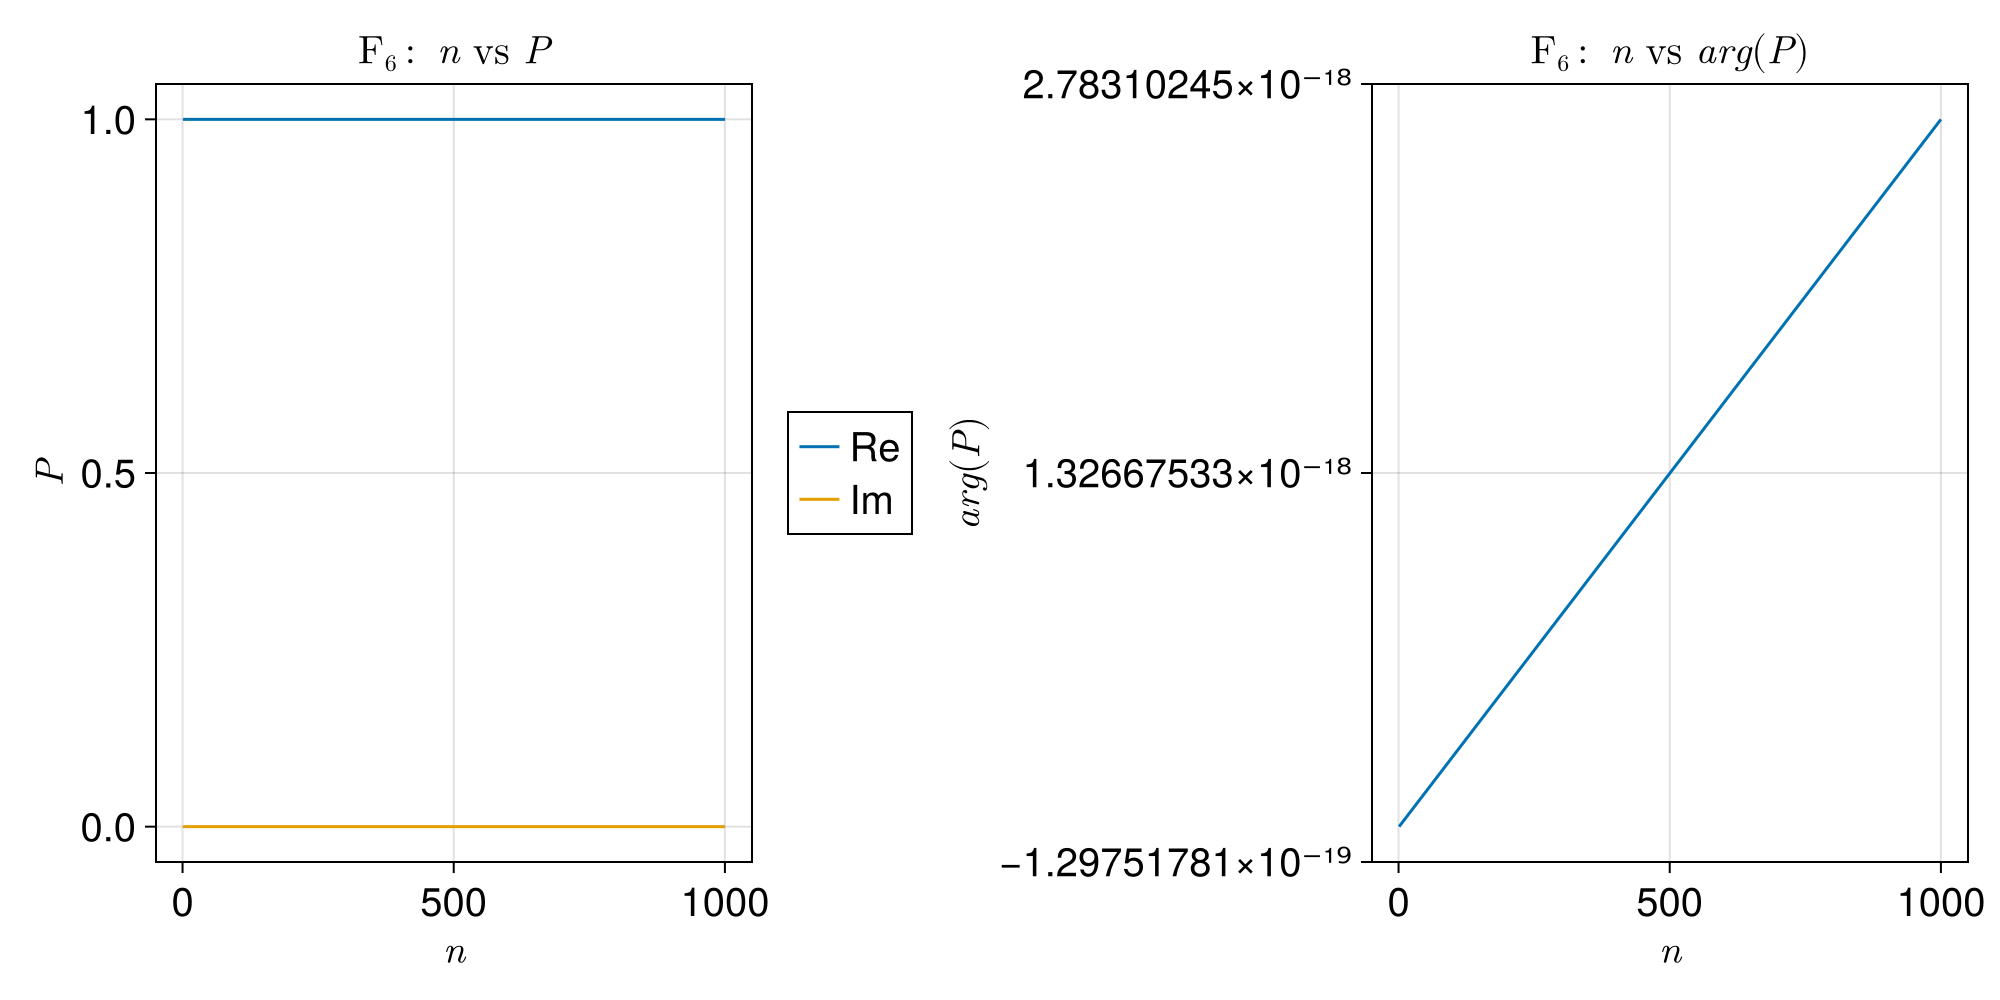

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194


In [33]:
# create plot
P = Figure(size=(1000, 500), fontsize=20)
# create and configure axes
ax = Axis(P[1, 1], title = L"\text{F_6: } n \text{ vs } P", xlabel = L"n", ylabel = L"P")
lines!(ax, n_list, real(F6_overlaps), label = "Re")
lines!(ax, n_list, imag(F6_overlaps), label = "Im")
P[1, 2] = Legend(P, ax, framevisible = true)
ax_theta = Axis(P[1, 3], title = L"\text{F_6: } n \text{ vs } arg(P)", xlabel = L"n", ylabel = L"arg(P)")
lines!(ax_theta, n_list, angle.(F6_overlaps))
P

<font size="12"> Hartree 6-Comp</font>

In [34]:
# parameters
a = 1
kappa = 4 * pi / (3 * a)
kF = (1e-10) * kappa
Vg = 1
# small deviation from high-symmetry point
num_pts = Int(1e2)

100

In [35]:
H6_overlaps = zeros(ComplexF64, num_pts)
n_list = range(1, 1000, num_pts)

1.0:10.090909090909092:1000.0

In [36]:
for j in 1:num_pts
    n = n_list[j]
    thetas = [0, pi/3, 2*pi/3, pi, 4*pi/3, 5*pi/3]
    momenta = kF * ones(length(thetas))
    states = zeros(ComplexF64, (length(thetas), 3))
    for i in 1:length(thetas)
        theta = thetas[i]
        ham = H_H(Vg, kF, kappa, n, a, omega, momenta[i], theta)
        gs = eigvecs(Hermitian(ham))[:, 1]
        states[i, :] = normalize(gs)
    end
    H6_overlaps[j] = overlap(states, thetas, momenta, kappa, a, n)
end

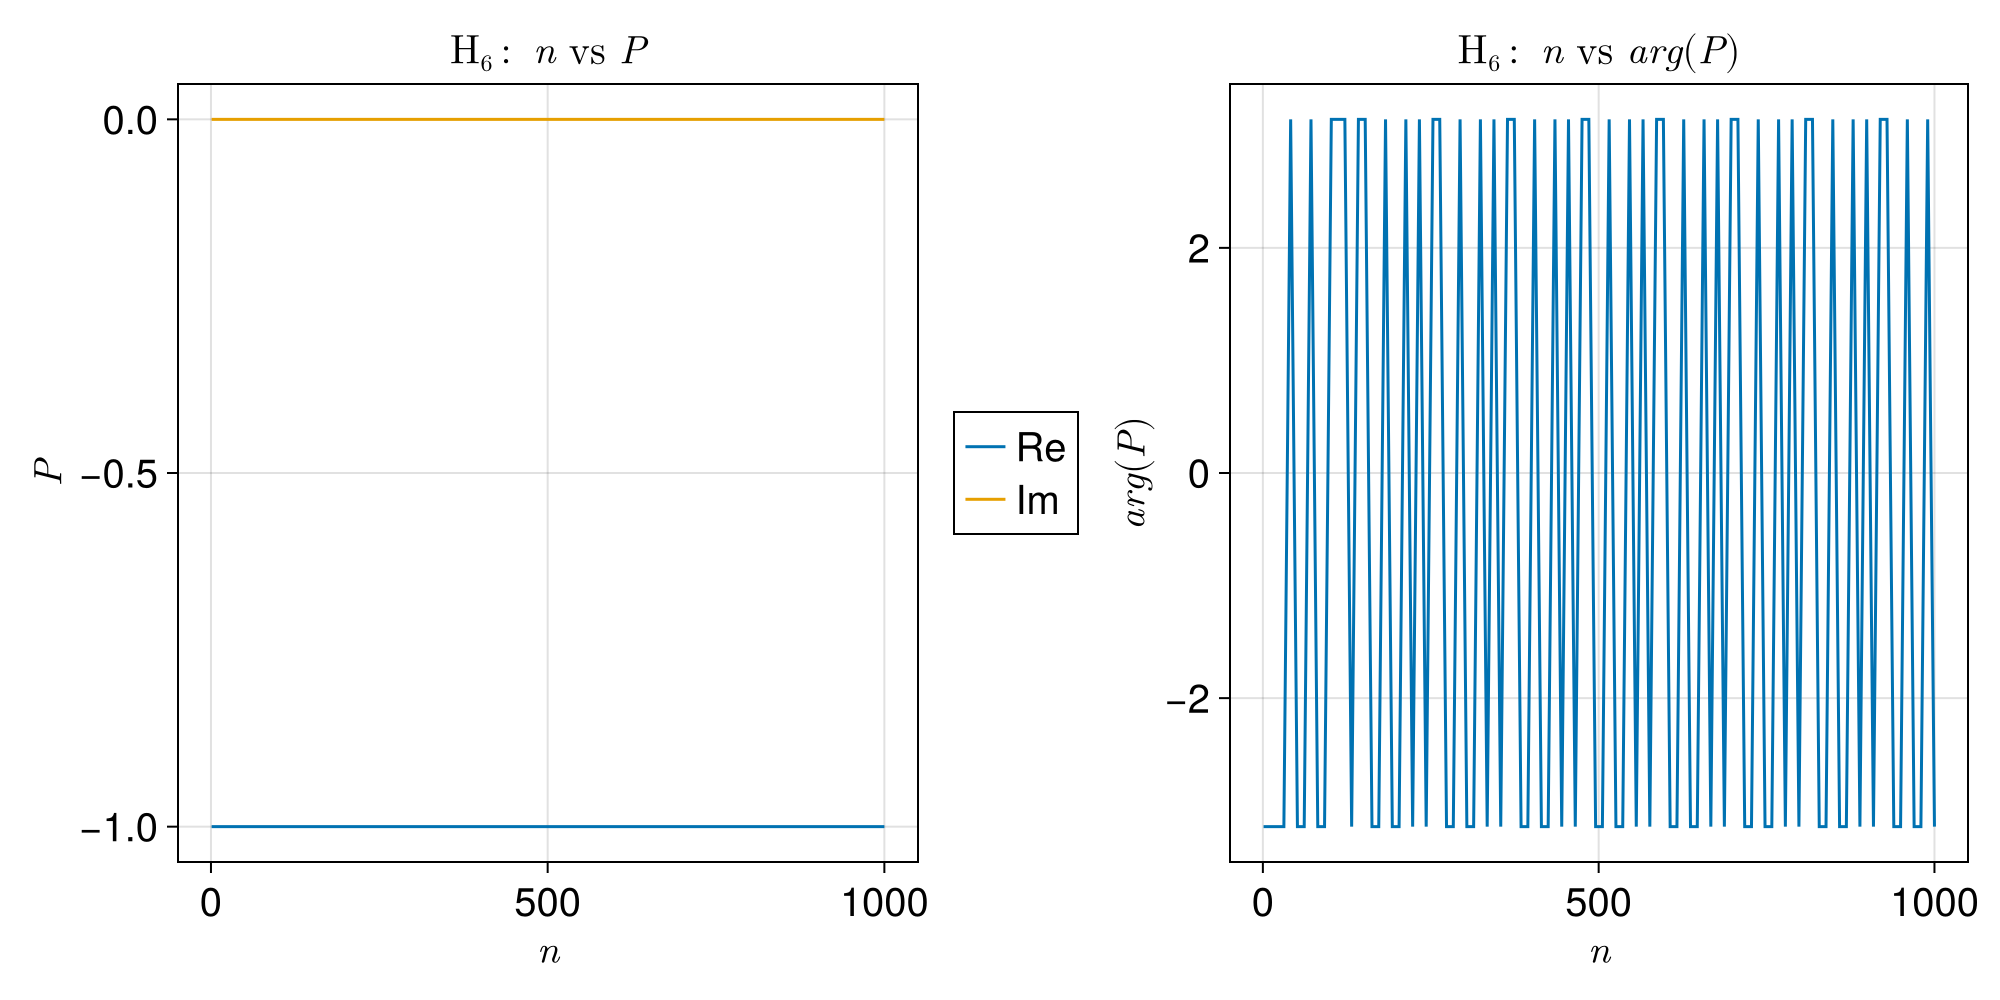

In [37]:
# create plot
P = Figure(size=(1000, 500), fontsize=20)
# create and configure axes
ax = Axis(P[1, 1], title =L"\text{H_6: } n \text{ vs } P", xlabel = L"n", ylabel = L"P")
lines!(ax, n_list, real(H6_overlaps), label = "Re")
lines!(ax, n_list, imag(H6_overlaps), label = "Im")
P[1, 2] = Legend(P, ax, framevisible = true)
ax_theta = Axis(P[1, 3], title = L"\text{H_6: } n \text{ vs } arg(P)", xlabel = L"n", ylabel = L"arg(P)")
lines!(ax_theta, n_list, angle.(H6_overlaps))
P

<font size="12">Hartree + Fock (6-Comp)</font>

In [38]:
# parameters
a = 1
kappa = 4 * pi / (3 * a)
kF = (1e-10) * kappa
Vg = 1
V0 = 1
# small deviation from high-symmetry point
num_pts = Int(1e2)

100

In [39]:
HF6_overlaps = zeros(ComplexF64, num_pts)
n_list = range(1, 1000, num_pts)

1.0:10.090909090909092:1000.0

In [40]:
for j in 1:num_pts
    n = n_list[j]
    thetas = [0, pi/3, 2*pi/3, pi, 4*pi/3, 5*pi/3]
    momenta = kF * ones(length(thetas))
    states = zeros(ComplexF64, (length(thetas), 3))
    for i in 1:length(thetas)
        theta = thetas[i]
        ham = H_H(Vg, kF, kappa, n, a, omega, momenta[i], theta) + H_F(V0, kF, kappa, n, a, omega, momenta[i], theta)
        gs = eigvecs(Hermitian(ham))[:, 1]
        states[i, :] = normalize(gs)
    end
    HF6_overlaps[j] = overlap(states, thetas, momenta, kappa, a, n)
end

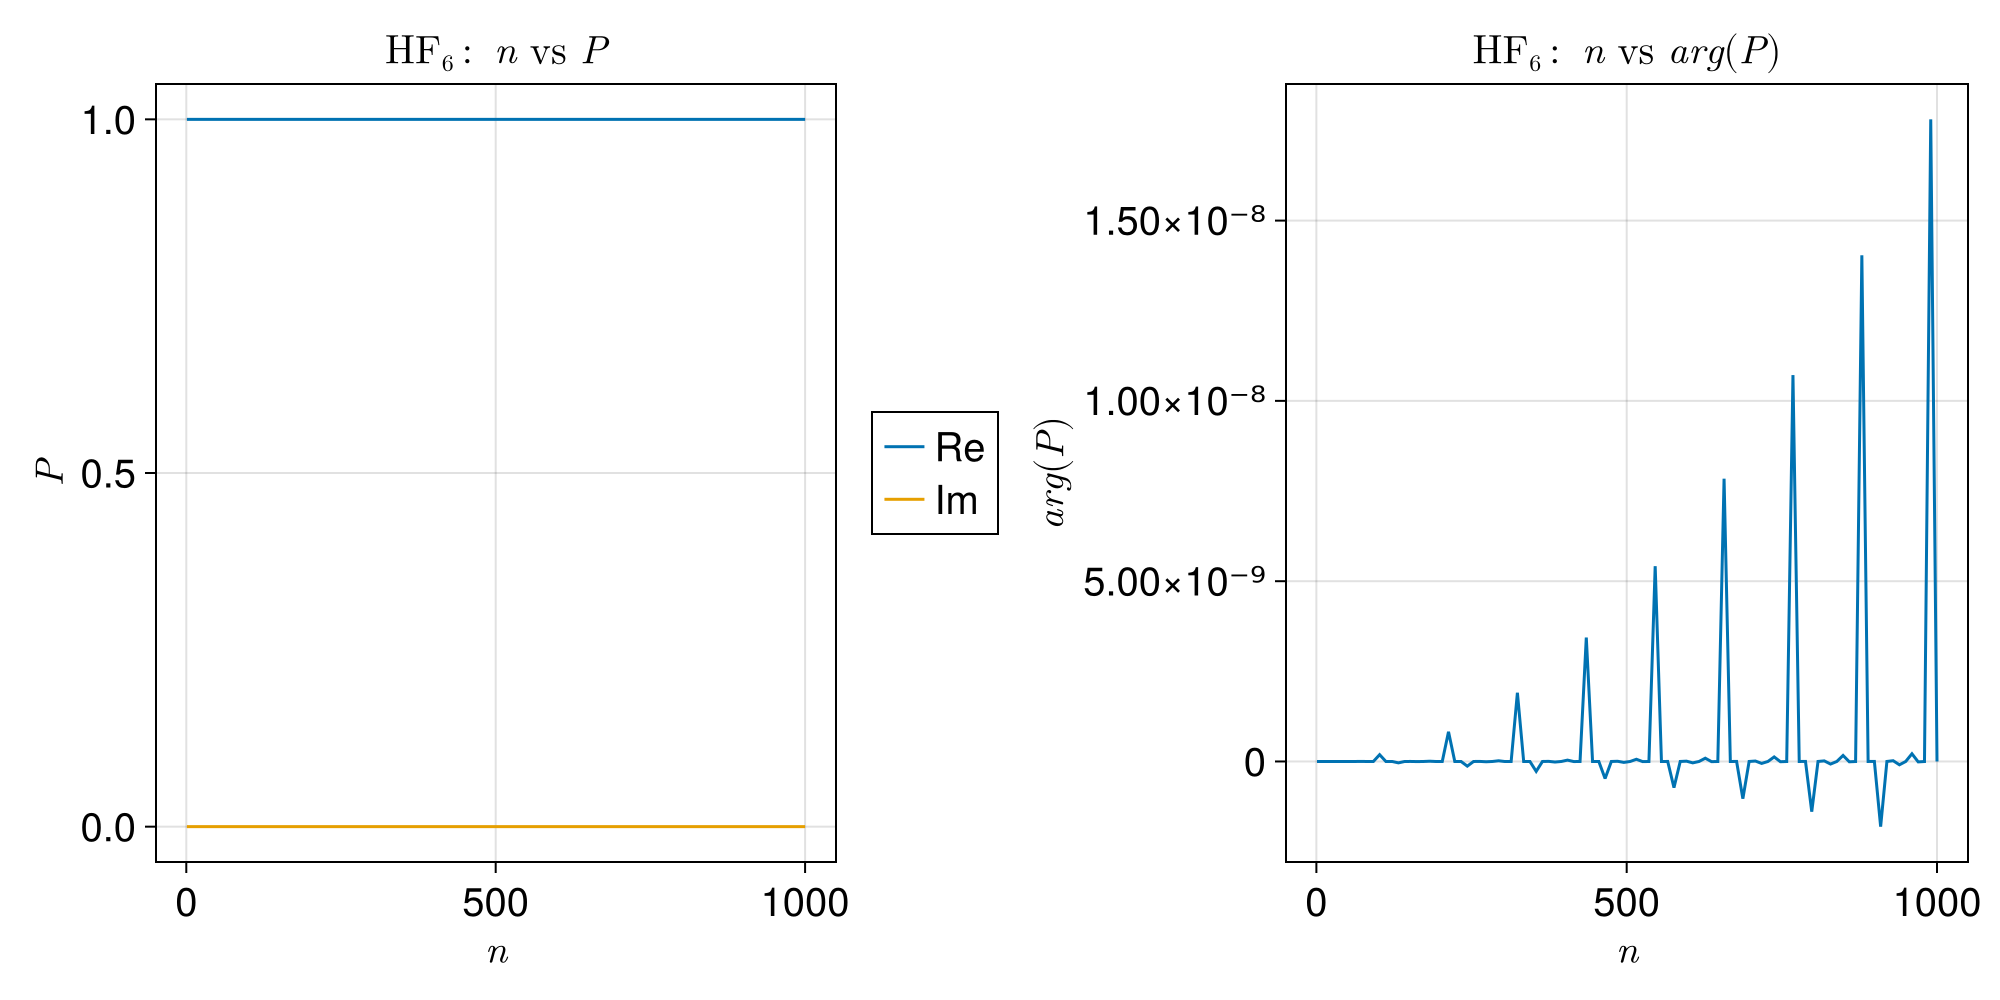

In [41]:
# create plot
P = Figure(size=(1000, 500), fontsize=20)
# create and configure axes
ax = Axis(P[1, 1], title = L"\text{HF_6: } n \text{ vs } P", xlabel = L"n", ylabel = L"P")
lines!(ax, n_list, real(HF6_overlaps), label = "Re")
lines!(ax, n_list, imag(HF6_overlaps), label = "Im")
P[1, 2] = Legend(P, ax, framevisible = true)
ax_theta = Axis(P[1, 3], title = L"\text{HF_6: } n \text{ vs } arg(P)", xlabel = L"n", ylabel = L"arg(P)")
lines!(ax_theta, n_list, angle.(HF6_overlaps))
P

<font size="12">Hartree vs Fock (6-Comp) for variable n</font>

In [42]:
# parameters
a = 1
kappa = 4 * pi / (3 * a)
kF = (10^-3) * kappa
Vg = 1
V0 = 1
# small deviation from high-symmetry point
num_pts = 10

10

In [43]:
F6_overlaps = zeros(ComplexF64, num_pts)
H6_overlaps = zeros(ComplexF64, num_pts)
HF6_overlaps = zeros(ComplexF64, num_pts)
n_list = range(1, 10, num_pts)

1.0:1.0:10.0

In [44]:
for j in 1:num_pts
    n = n_list[j]
    thetas = [0, pi/3, 2*pi/3, pi, 4*pi/3, 5*pi/3]
    momenta = kF * ones(length(thetas))
    statesH = zeros(ComplexF64, (length(thetas), 3))
    statesF = zeros(ComplexF64, (length(thetas), 3))
    statesHF = zeros(ComplexF64, (length(thetas), 3))
    for i in 1:length(thetas)
        theta = thetas[i]

        hamF = H_F(V0, kF, kappa, n, a, omega, momenta[i], theta)
        hamH = H_H(Vg, kF, kappa, n, a, omega, momenta[i], theta)
        hamHF = H_H(Vg, kF, kappa, n, a, omega, momenta[i], theta) + H_F(V0, kF, kappa, n, a, omega, momenta[i], theta)

        gsF = eigvecs(Hermitian(hamF))[:, 1]
        gsH = eigvecs(Hermitian(hamH))[:, 1]
        gsHF = eigvecs(Hermitian(hamHF))[:, 1]

        statesF[i, :] = normalize(gsF)
        statesH[i, :] = normalize(gsH)
        statesHF[i, :] = normalize(gsHF)
    end
    F6_overlaps[j] = overlap(statesF, thetas, momenta, kappa, a, n)
    H6_overlaps[j] = overlap(statesH, thetas, momenta, kappa, a, n)
    HF6_overlaps[j] = overlap(statesHF, thetas, momenta, kappa, a, n)
end


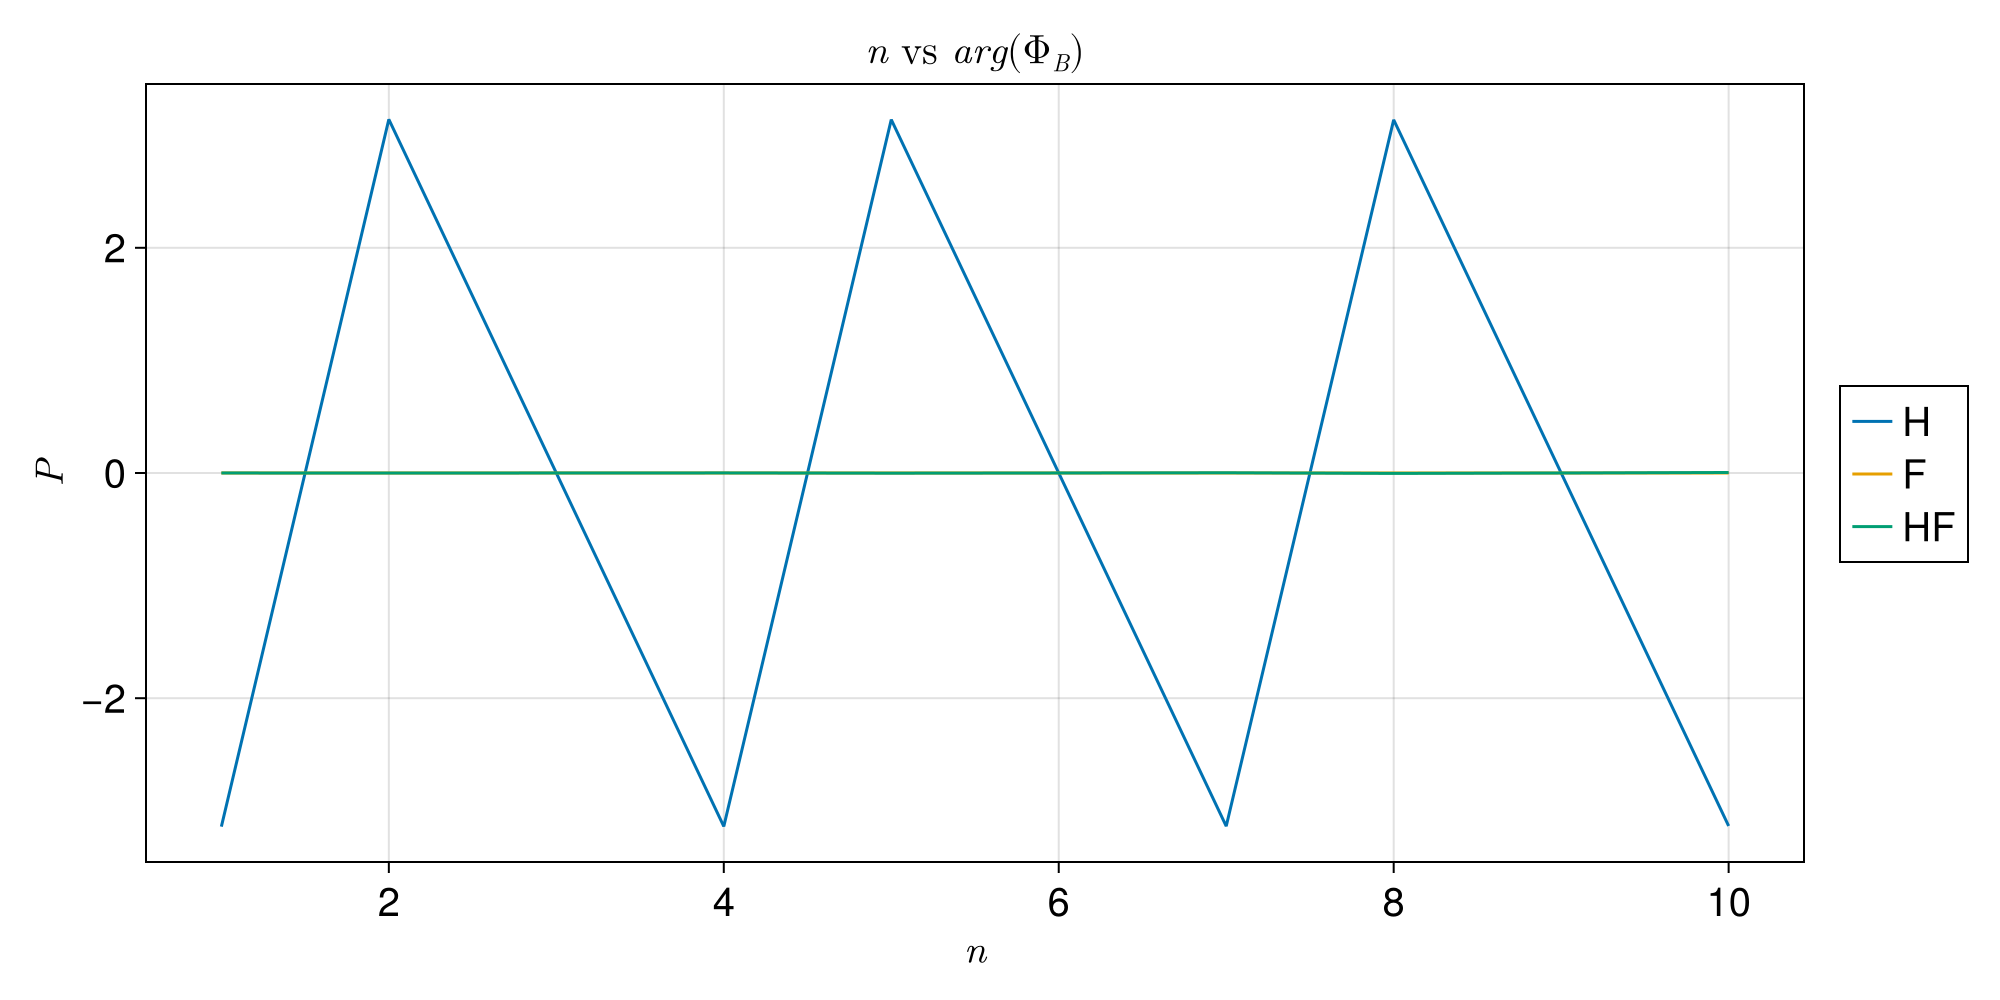

In [45]:
# create plot
P = Figure(size=(1000, 500), fontsize=20)
# create and configure axes
ax = Axis(P[1, 1], title = L"n \text{ vs } arg(\Phi_B)", xlabel = L"n", ylabel = L"P")
lines!(ax, n_list, angle.(H6_overlaps), label = "H")
lines!(ax, n_list, angle.(F6_overlaps), label = "F")
lines!(ax, n_list, angle.(HF6_overlaps), label = "HF")
P[1, 2] = Legend(P, ax, framevisible = true)
P

<font size="12">Hartree vs Fock (6-Comp) for variable q</font>

In [46]:
# parameters
a = 1
kappa = 4 * pi / (3 * a)
kF = (1e-6) * kappa
Vg = 1
V0 = 1
# small deviation from high-symmetry point
n = 10^2
num_pts = 10^2

100

In [47]:
F6_overlaps_q = zeros(ComplexF64, num_pts)
H6_overlaps_q = zeros(ComplexF64, num_pts)
HF6_overlaps_q = zeros(ComplexF64, num_pts)
q_list = range(10^(-2)*kF, kF, num_pts)

4.188790204786391e-8:4.1887902047863906e-8:4.1887902047863905e-6

In [48]:
for j in 1:num_pts
    q = q_list[j]
    thetas = [0, pi/3, 2*pi/3, pi, 4*pi/3, 5*pi/3]
    momenta = q * ones(length(thetas))
    statesH = zeros(ComplexF64, (length(thetas), 3))
    statesF = zeros(ComplexF64, (length(thetas), 3))
    statesHF = zeros(ComplexF64, (length(thetas), 3))
    for i in 1:length(thetas)
        theta = thetas[i]

        hamF = H_F(V0, kF, kappa, n, a, omega, momenta[i], theta)
        hamH = H_H(Vg, kF, kappa, n, a, omega, momenta[i], theta)
        hamHF = H_H(Vg, kF, kappa, n, a, omega, momenta[i], theta) + H_F(V0, kF, kappa, n, a, omega, momenta[i], theta)

        gsF = eigvecs(Hermitian(hamF))[:, 1]
        gsH = eigvecs(Hermitian(hamH))[:, 1]
        gsHF = eigvecs(Hermitian(hamHF))[:, 1]

        statesF[i, :] = normalize(gsF)
        statesH[i, :] = normalize(gsH)
        statesHF[i, :] = normalize(gsHF)
    end
    F6_overlaps_q[j] = overlap(statesF, thetas, momenta, kappa, a, n)
    H6_overlaps_q[j] = overlap(statesH, thetas, momenta, kappa, a, n)
    HF6_overlaps_q[j] = overlap(statesHF, thetas, momenta, kappa, a, n)
end

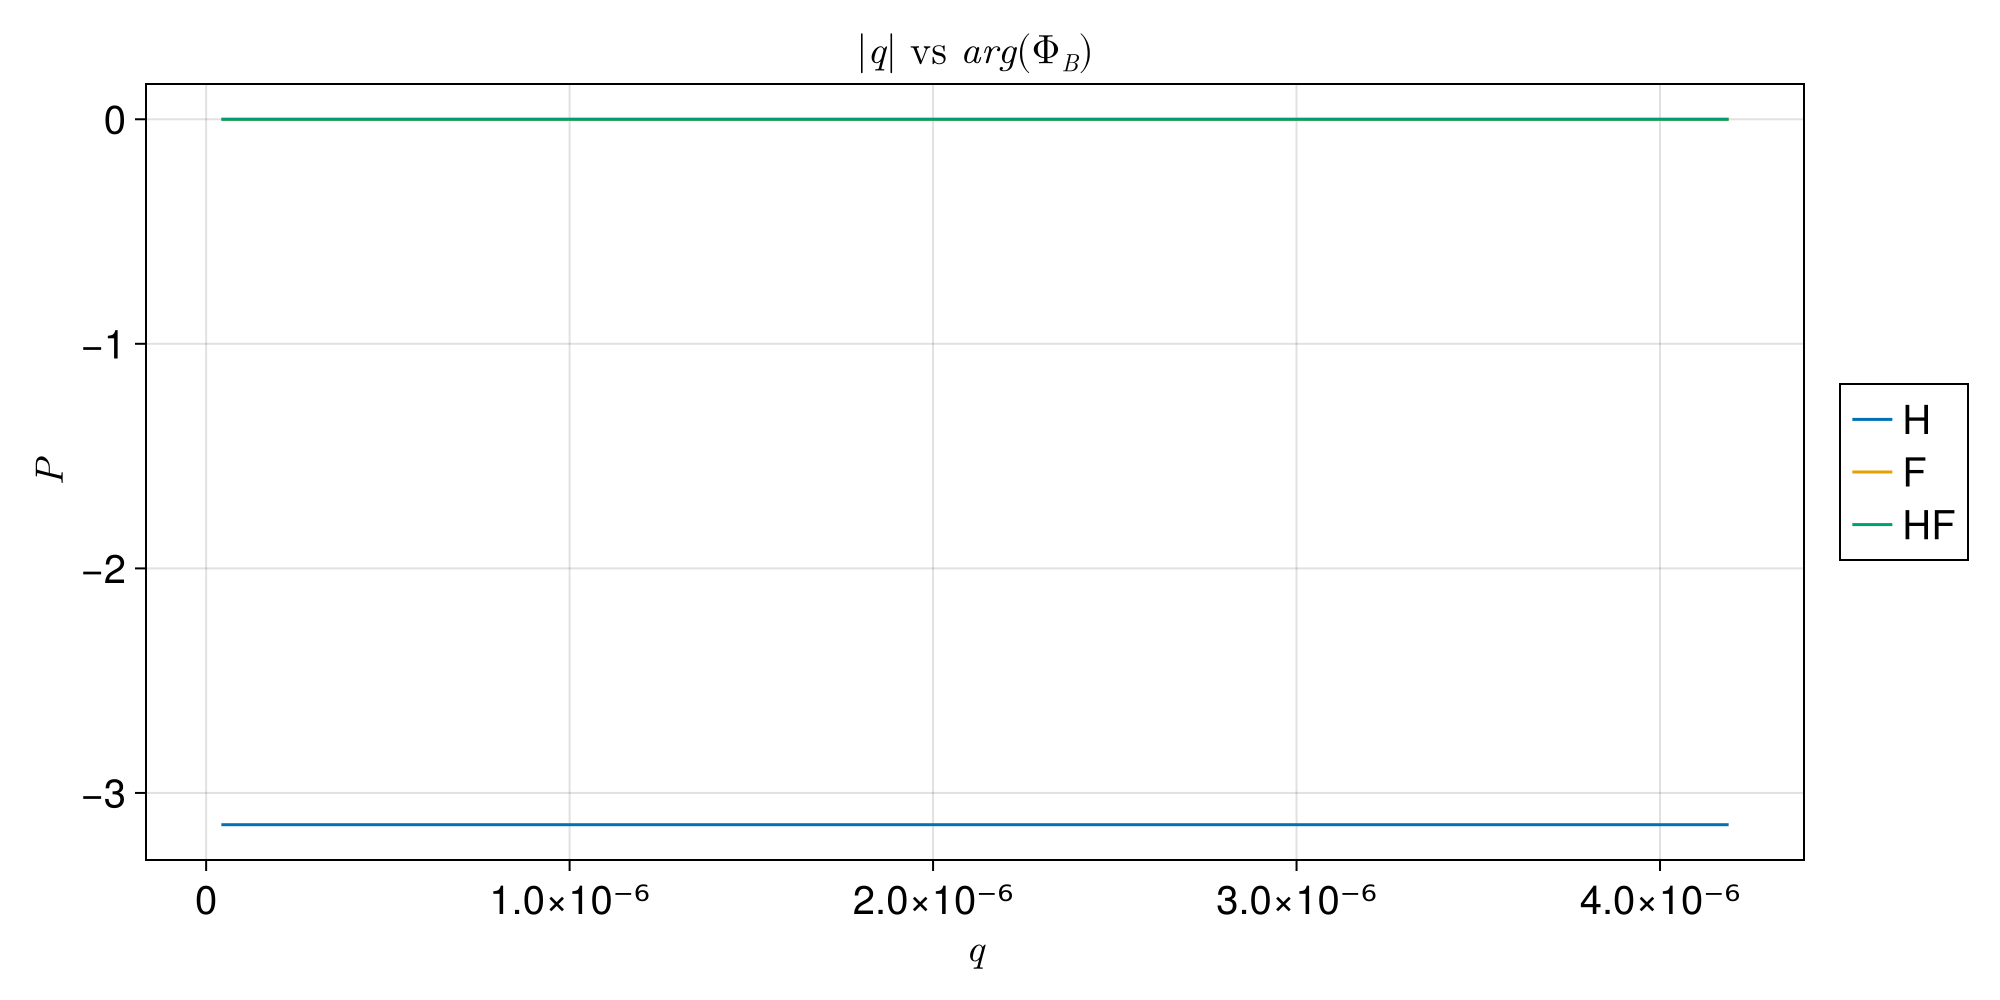

In [49]:
# create plot
P = Figure(size=(1000, 500), fontsize=20)
# create and configure axes
ax = Axis(P[1, 1], title = L"|q| \text{ vs } arg(\Phi_B)", xlabel = L"q", ylabel = L"P")
lines!(ax, q_list, angle.(H6_overlaps_q), label = "H")
lines!(ax, q_list, angle.(F6_overlaps_q), label = "F")
lines!(ax, q_list, angle.(HF6_overlaps_q), label = "HF")
P[1, 2] = Legend(P, ax, framevisible = true)
P

<font size="12">Hartree vs Fock (6-Comp) with kinetic (variable n)</font>

In [50]:
# parameters
a = 1
kappa = 4 * pi / (3 * a)
kF = (10^-6) * kappa
Vg = 1
V0 = 1
vF = 10^(-2)
# small deviation from high-symmetry point
num_pts = 10^3

1000

In [51]:
F6_overlaps_kin = zeros(ComplexF64, num_pts)
H6_overlaps_kin = zeros(ComplexF64, num_pts)
HF6_overlaps_kin = zeros(ComplexF64, num_pts)
n_list = range(1, 1000, num_pts)

1.0:1.0:1000.0

In [52]:
for j in 1:num_pts
    n = n_list[j]
    thetas = [0, pi/3, 2*pi/3, pi, 4*pi/3, 5*pi/3]
    momenta = kF * ones(length(thetas))
    statesH = zeros(ComplexF64, (length(thetas), 3))
    statesF = zeros(ComplexF64, (length(thetas), 3))
    statesHF = zeros(ComplexF64, (length(thetas), 3))
    for i in 1:length(thetas)
        theta = thetas[i]

        hamF = H_F(V0, kF, kappa, n, a, omega, momenta[i], theta) + H_k(vF, momenta[i], theta)
        hamH = H_H(Vg, kF, kappa, n, a, omega, momenta[i], theta) + H_k(vF, momenta[i], theta)
        hamHF = H_H(Vg, kF, kappa, n, a, omega, momenta[i], theta) + H_F(V0, kF, kappa, n, a, omega, momenta[i], theta) + H_k(vF, momenta[i], theta)

        gsF = eigvecs(Hermitian(hamF))[:, 1]
        gsH = eigvecs(Hermitian(hamH))[:, 1]
        gsHF = eigvecs(Hermitian(hamHF))[:, 1]

        statesF[i, :] = normalize(gsF)
        statesH[i, :] = normalize(gsH)
        statesHF[i, :] = normalize(gsHF)
    end
    F6_overlaps_kin[j] = overlap(statesF, thetas, momenta, kappa, a, n)
    H6_overlaps_kin[j] = overlap(statesH, thetas, momenta, kappa, a, n)
    HF6_overlaps_kin[j] = overlap(statesHF, thetas, momenta, kappa, a, n)
end

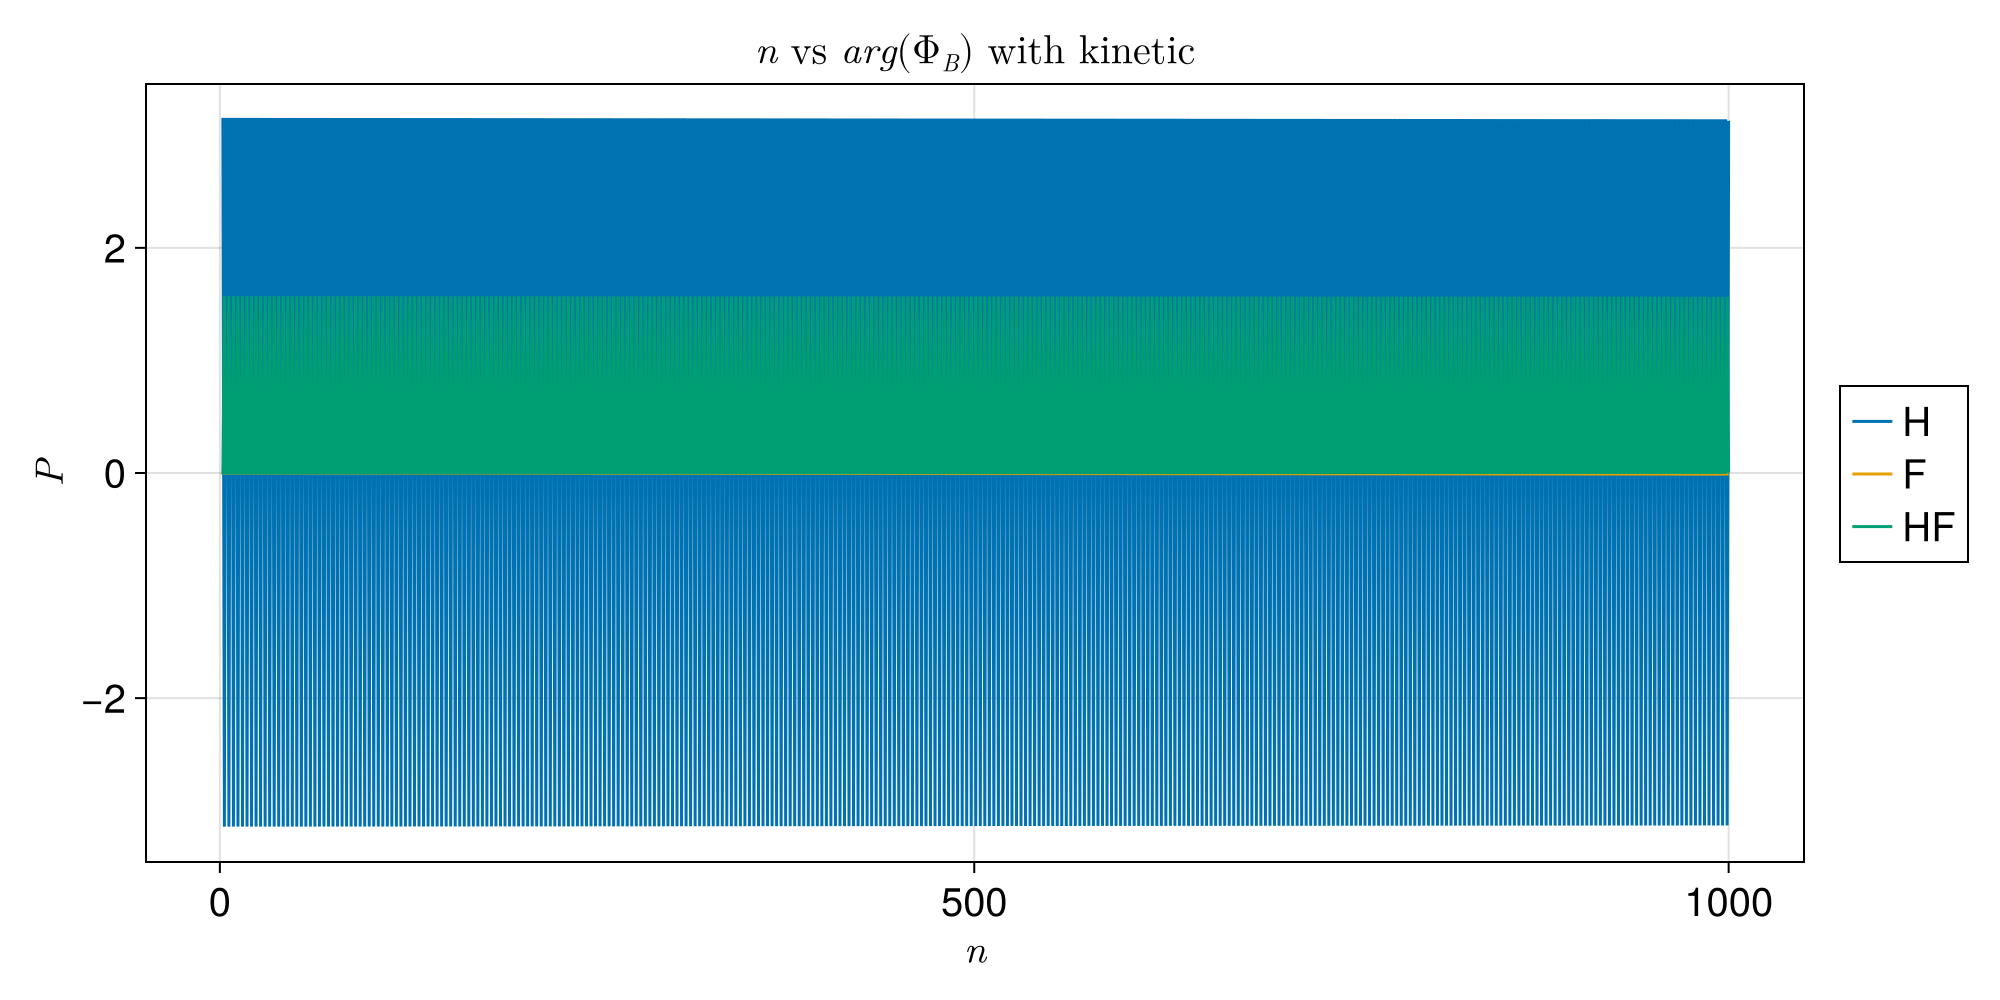

In [53]:
# create plot
P = Figure(size=(1000, 500), fontsize=20)
# create and configure axes
ax = Axis(P[1, 1], title = L"n \text{ vs } arg(\Phi_B) \text{ with kinetic}", xlabel = L"n", ylabel = L"P")
lines!(ax, n_list, angle.(H6_overlaps_kin), label = "H")
lines!(ax, n_list, angle.(F6_overlaps_kin), label = "F")
lines!(ax, n_list, angle.(HF6_overlaps_kin), label = "HF")
P[1, 2] = Legend(P, ax, framevisible = true)
P

<font size="12">Hartree vs Fock (6-Comp) with kinetic (variable q)</font>

In [54]:
# parameters
a = 1
kappa = 4 * pi / (3 * a)
kF = (1e-6) * kappa
Vg = 1
V0 = 1
vF = 10^(-2)
# small deviation from high-symmetry point
n = 10^12
num_pts = 10^3

1000

In [55]:
F6_overlaps_qkin = zeros(ComplexF64, num_pts)
H6_overlaps_qkin = zeros(ComplexF64, num_pts)
HF6_overlaps_qkin = zeros(ComplexF64, num_pts)
q_list = range(kF * 10^(-2), kF, num_pts)

4.188790204786391e-8:4.151053356094621e-9:4.1887902047863905e-6

In [56]:
for j in 1:num_pts
    q = q_list[j]
    thetas = [0, pi/3, 2*pi/3, pi, 4*pi/3, 5*pi/3]
    momenta = q * ones(length(thetas))
    statesH = zeros(ComplexF64, (length(thetas), 3))
    statesF = zeros(ComplexF64, (length(thetas), 3))
    statesHF = zeros(ComplexF64, (length(thetas), 3))
    for i in 1:length(thetas)
        theta = thetas[i]

        hamF = H_F(V0, kF, kappa, n, a, omega, momenta[i], theta) + H_k(vF, momenta[i], theta)
        hamH = H_H(Vg, kF, kappa, n, a, omega, momenta[i], theta) + H_k(vF, momenta[i], theta)
        hamHF = H_H(Vg, kF, kappa, n, a, omega, momenta[i], theta) + H_F(V0, kF, kappa, n, a, omega, momenta[i], theta) + H_k(vF, momenta[i], theta)

        gsF = eigvecs(Hermitian(hamF))[:, 1]
        gsH = eigvecs(Hermitian(hamH))[:, 1]
        gsHF = eigvecs(Hermitian(hamHF))[:, 1]

        statesF[i, :] = normalize(gsF)
        statesH[i, :] = normalize(gsH)
        statesHF[i, :] = normalize(gsHF)
    end
    F6_overlaps_qkin[j] = overlap(statesF, thetas, momenta, kappa, a, n)
    H6_overlaps_qkin[j] = overlap(statesH, thetas, momenta, kappa, a, n)
    HF6_overlaps_qkin[j] = overlap(statesHF, thetas, momenta, kappa, a, n)
end

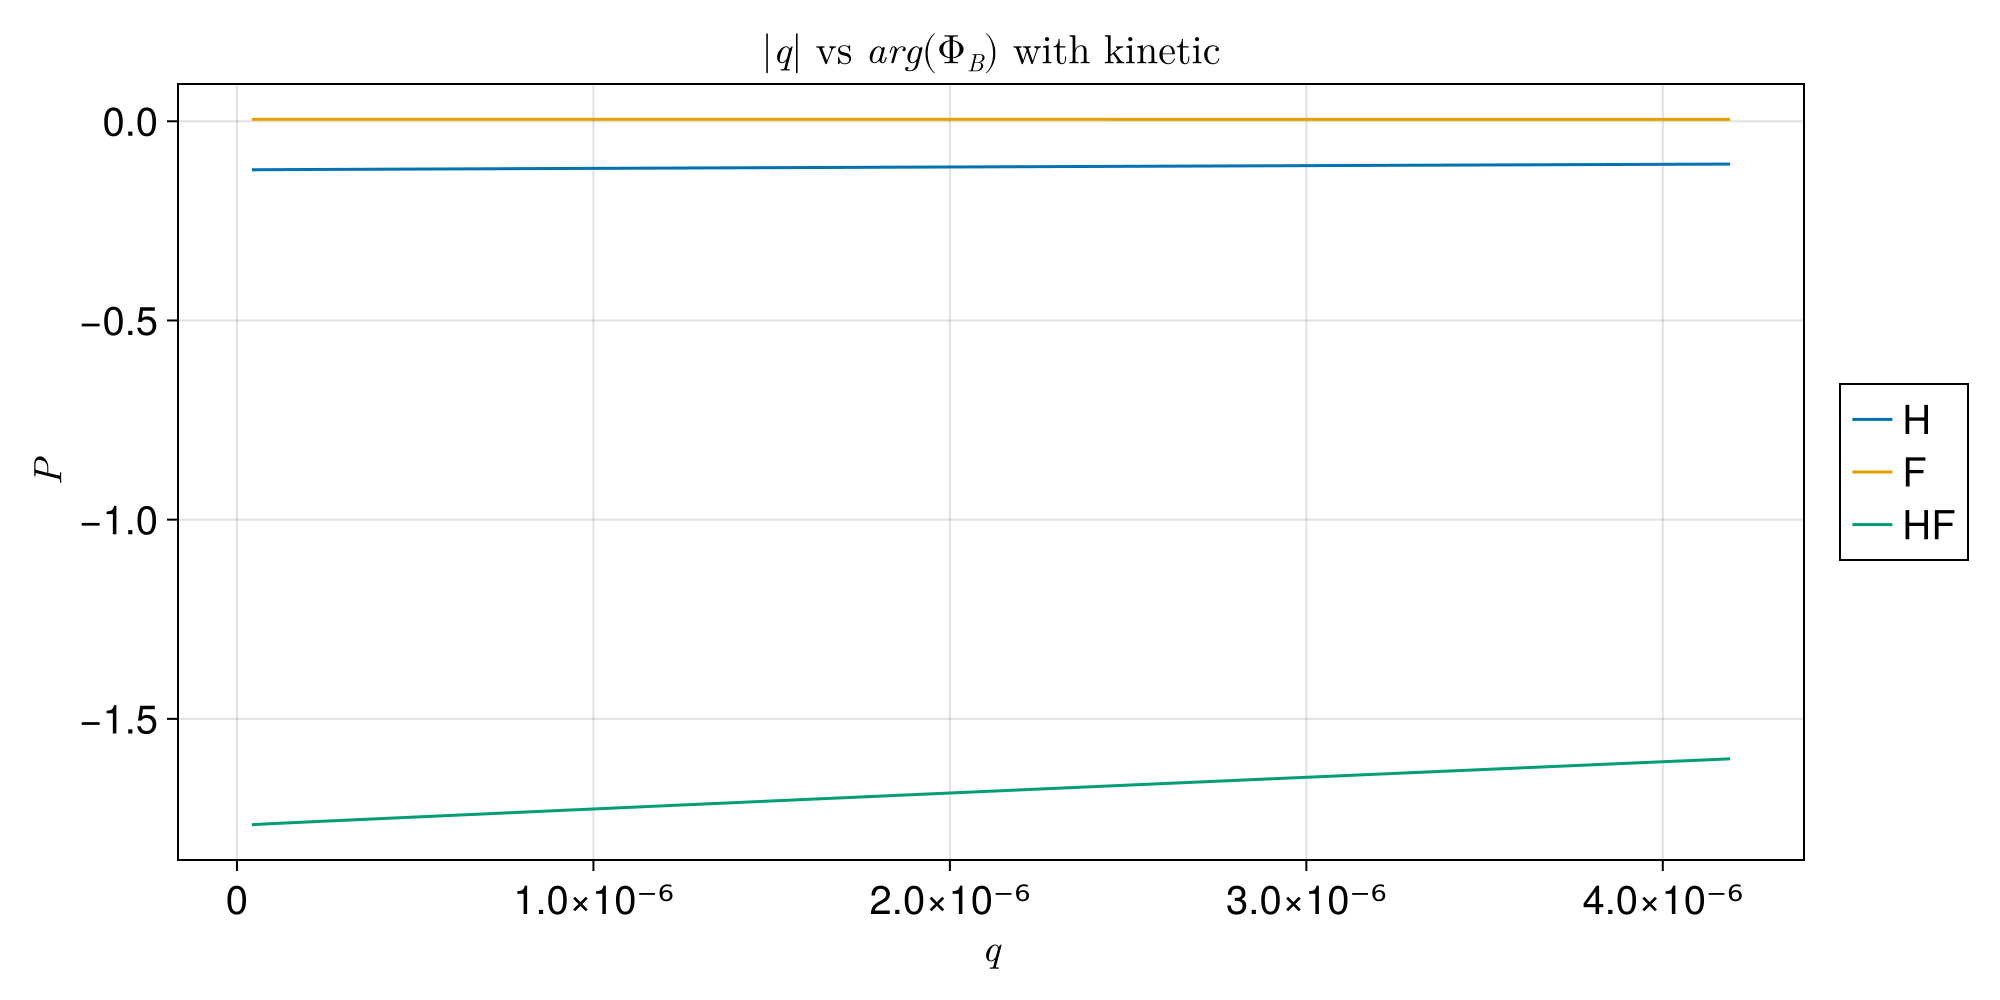

In [57]:
# create plot
P = Figure(size=(1000, 500), fontsize=20)
# create and configure axes
ax = Axis(P[1, 1], title = L"|q| \text{ vs } arg(\Phi_B) \text{ with kinetic}", xlabel = L"q", ylabel = L"P")
lines!(ax, q_list, angle.(H6_overlaps_qkin), label = "H")
lines!(ax, q_list, angle.(F6_overlaps_qkin), label = "F")
lines!(ax, q_list, angle.(HF6_overlaps_qkin), label = "HF")
P[1, 2] = Legend(P, ax, framevisible = true)
P

<font size="12">Berry Curvature Distribution</font>

In [58]:
function polar_angle(x, y)
    if x < 0
        return atan(y/x) + pi
    else
        return atan(y/x)
    end
end

polar_angle (generic function with 1 method)

In [61]:
# compute the phase difference between wavefunction at (x1, y1) and (x2, y2)
function theta_ang(ham2, ham1, kappa, a, n, q2, q1, theta2, theta1)
    ev1 = normalize(eigvecs(Hermitian(ham1))[:, 1])
    ev2 = normalize(eigvecs(Hermitian(ham2))[:, 1])
    prod = inner_p(ev2, ev1, kappa, a, n, q2, q1, theta2, theta1)
    return prod / abs(prod)
end

theta_ang (generic function with 1 method)

In [62]:
# Berry flux through a plaquette with corners (x1, y1), (x2, y2), (x3, y3), (x4, y4)
function flux(ham1, ham2, ham3, ham4, kappa, a, n, q4, q3, q2, q1, theta4, theta3, theta2, theta1)
    big_theta = theta_ang(ham1, ham2, kappa, a, n, q1, q2, theta1, theta2) * theta_ang(ham2, ham3, kappa, a, n, q2, q3, theta2, theta3) * 
    theta_ang(ham3, ham4, kappa, a, n, q3, q4, theta3, theta4) * theta_ang(ham4, ham1, kappa, a, n, q4, q1, theta4, theta1)
    # Numerical instability around flux = pi, so we always force it to choose +pi
    if abs(imag(big_theta)) < 10^(-14)
        return abs(angle(big_theta))
    else
        return angle(big_theta)
    end
end

flux (generic function with 1 method)

In [63]:
# Berry curvature over all plaquettes
function berry_curvature(points, spacing, V0, Vg, kF, kappa, n, a, omega, vF, triv = false)
    berry_list = Array{Float64}(undef, size(points)[1])
    for i in 1:size(points)[1]
        # get flux through square plaquette centered at point
        angles = Array{Float64}(undef, 6)
        momenta = Array{Float64}(undef, length(angles))
        for j in 1:length(angles)
            x_new = points[i, 1] + spacing * cos(pi/3 * (j - 1))
            y_new = points[i, 2] + spacing * sin(pi/3 * (j - 1))
            momenta[j] = norm([x_new, y_new])
            angles[j] = polar_angle(x_new, y_new)
        end

        states = Array{ComplexF64}(undef, length(angles), 3)
        for j in 1:length(angles)
            if triv == true
                temp_ham = H0(V0, Vg, kF, kappa, n) + H_k(vF, momenta[j], angles[j])
                states[j, :] = normalize(eigvecs(Hermitian(temp_ham))[:, 1])
            else
                temp_ham = H_H(Vg, kF, kappa, n, a, omega, momenta[j], angles[j]) + H_F(V0, kF, kappa, n, a, omega, momenta[j], angles[j]) + 
                H_k(vF, momenta[j], angles[j])
                states[j, :] = normalize(eigvecs(Hermitian(temp_ham))[:, 1])
            end
        end
        
        P = overlap(states, angles, momenta, kappa, a, n)
        if abs(imag(P)) < 10^(-14)
            berry_list[i] = abs(angle(P))
        else
            berry_list[i] = angle(P)
        end
    end
    return berry_list
end

berry_curvature (generic function with 2 methods)

In [64]:
# This generates a line of points in K-space
function make_line(x0, x1, n, y)
    x_vals = range(x0, x1, n)
    line_vals = Array{Float64}(undef, n, 2)
    for i in 1:n
        line_vals[i, :] = [x_vals[i], y]
    end
    return line_vals
end

# draw a square around k of dimensions radius x radius (with point-density n)
function k_zone(k, den, radius)
    kx = k[1]
    ky = k[2]
    grid = Array{Float64}(undef, den, den, 2)
    ky_pts = range(ky - radius/2, ky + radius/2, den)
    for i in 1:den
        grid[:, i, :] = make_line(kx - radius/2, kx + radius/2, den, ky_pts[i])
    end
    return reshape(grid, (den^2, 2))
end
function hex_grid(k, den, len)
    kx = k[1]
    ky = k[2]
    points = Array{Float64}(undef, den, den, 2)
    ky_pts = range(ky - len/2, ky + len/2, den)
    h = trunc(Int, den/2)
    # upper
    for j in 1:h
        xlim = len - (h - j) * len / den
        y = ky_pts[den + 1 - j]
        points[:, j, :] = make_line(-xlim, xlim, den, y)
    end
    # lower
    for j in 1:h
        xlim = len - (h - j) * len / den
        y = ky_pts[j]
        points[:, h + j, :] = make_line(-xlim, xlim, den, y)
    end
    # Add mid-line if necessary
    if den % 2 == 1
        xlim = len
        y = ky_pts[h + 1]
        points[:, den, :] = make_line(-xlim, xlim, den, y)
    end
    return reshape(points, (den^2, 2))
end

hex_grid (generic function with 1 method)

In [361]:
function hexagon_vertices(center, radius)
    angles = [pi/3 * i for i in 0:5]
    [[center[1] + radius * cos(θ), center[2] + radius * sin(θ)] for θ in angles]
end

# Function to check if a point is inside the hexagon
function point_in_hexagon(point, hexagon)
    x, y = point
    x_min = minimum([v[1] for v in hexagon])
    x_max = maximum([v[1] for v in hexagon])
    y_min = minimum([v[2] for v in hexagon])
    y_max = maximum([v[2] for v in hexagon])

    if x < x_min || x > x_max || y < y_min || y > y_max
        return false
    end

    # Use ray-casting algorithm to check if point is inside the polygon
    n = length(hexagon)
    inside = false
    for i in 1:n
        j = i % n + 1
        xi, yi = hexagon[i]
        xj, yj = hexagon[j]
        if ((yi > y) != (yj > y)) && (x < (xj - xi) * (y - yi) / (yj - yi) + xi)
            inside = !inside
        end
    end
    return inside
end
function make_hex(center, rad, spacing)
    hexagon = hexagon_vertices(center, rad)
    counter = 0
    x_coords = []
    y_coords = []
    for x in -rad:spacing:rad
        for y in -rad:spacing:rad
            if point_in_hexagon([x, y], hexagon)
                push!(x_coords, x)
                push!(y_coords, y)
                counter += 1
            end
        end
    end
    points = Array{Float64}(undef, counter, 2)
    points[:, 1] = x_coords
    points[:, 2] = y_coords
    return points
end

make_hex (generic function with 1 method)

In [369]:
# parameters
a = 1
kappa = 4 * pi / (3 * a)
kF = 10^(-4) * kappa
n = 3
vF = 10^(-2)

0.010000000000000002

In [382]:
pd = 50
spacing = 10^(-1) * (kF / pd)
grid = hex_grid([0, 0], pd, kF)

2500×2 Matrix{Float64}:
 -0.000217817   0.00020944
 -0.000208927   0.00020944
 -0.000200036   0.00020944
 -0.000191146   0.00020944
 -0.000182255   0.00020944
 -0.000173365   0.00020944
 -0.000164474   0.00020944
 -0.000155584   0.00020944
 -0.000146693   0.00020944
 -0.000137803   0.00020944
 -0.000128912   0.00020944
 -0.000120022   0.00020944
 -0.000111131   0.00020944
  ⋮            
  0.000230811  -4.27428e-6
  0.000247908  -4.27428e-6
  0.000265005  -4.27428e-6
  0.000282102  -4.27428e-6
  0.000299199  -4.27428e-6
  0.000316296  -4.27428e-6
  0.000333394  -4.27428e-6
  0.000350491  -4.27428e-6
  0.000367588  -4.27428e-6
  0.000384685  -4.27428e-6
  0.000401782  -4.27428e-6
  0.000418879  -4.27428e-6

In [383]:
H_curvature = berry_curvature(grid, spacing, 0, 1, kF, kappa, n, a, omega, vF)
F_curvature = berry_curvature(grid, spacing, 1, 0, kF, kappa, n, a, omega, vF)
HF_curvature = berry_curvature(grid, spacing, 1, 1, kF, kappa, n, a, omega, vF)
triv_curvature = berry_curvature(grid, spacing, 1, 1, kF, kappa, n, a, omega, vF, true)

2500-element Vector{Float64}:
 3.180977525673044e-14
 3.180974412826963e-14
 3.180972951695129e-14
 3.1809583721405243e-14
 3.1809487159649256e-14
 3.180952157036274e-14
 3.180945783113346e-14
 3.180936073998188e-14
 3.180931330613683e-14
 3.1809233367402435e-14
 3.180910408899886e-14
 3.180925054850154e-14
 3.1809282814329635e-14
 ⋮
 3.180923961427042e-14
 3.180930091827998e-14
 3.180936190465218e-14
 3.180945359596872e-14
 3.1809514476461805e-14
 3.180960606189923e-14
 3.180963708448092e-14
 3.180963782563475e-14
 3.1809759057225325e-14
 3.180972951695129e-14
 3.1809881347607085e-14
 3.1809942545737524e-14

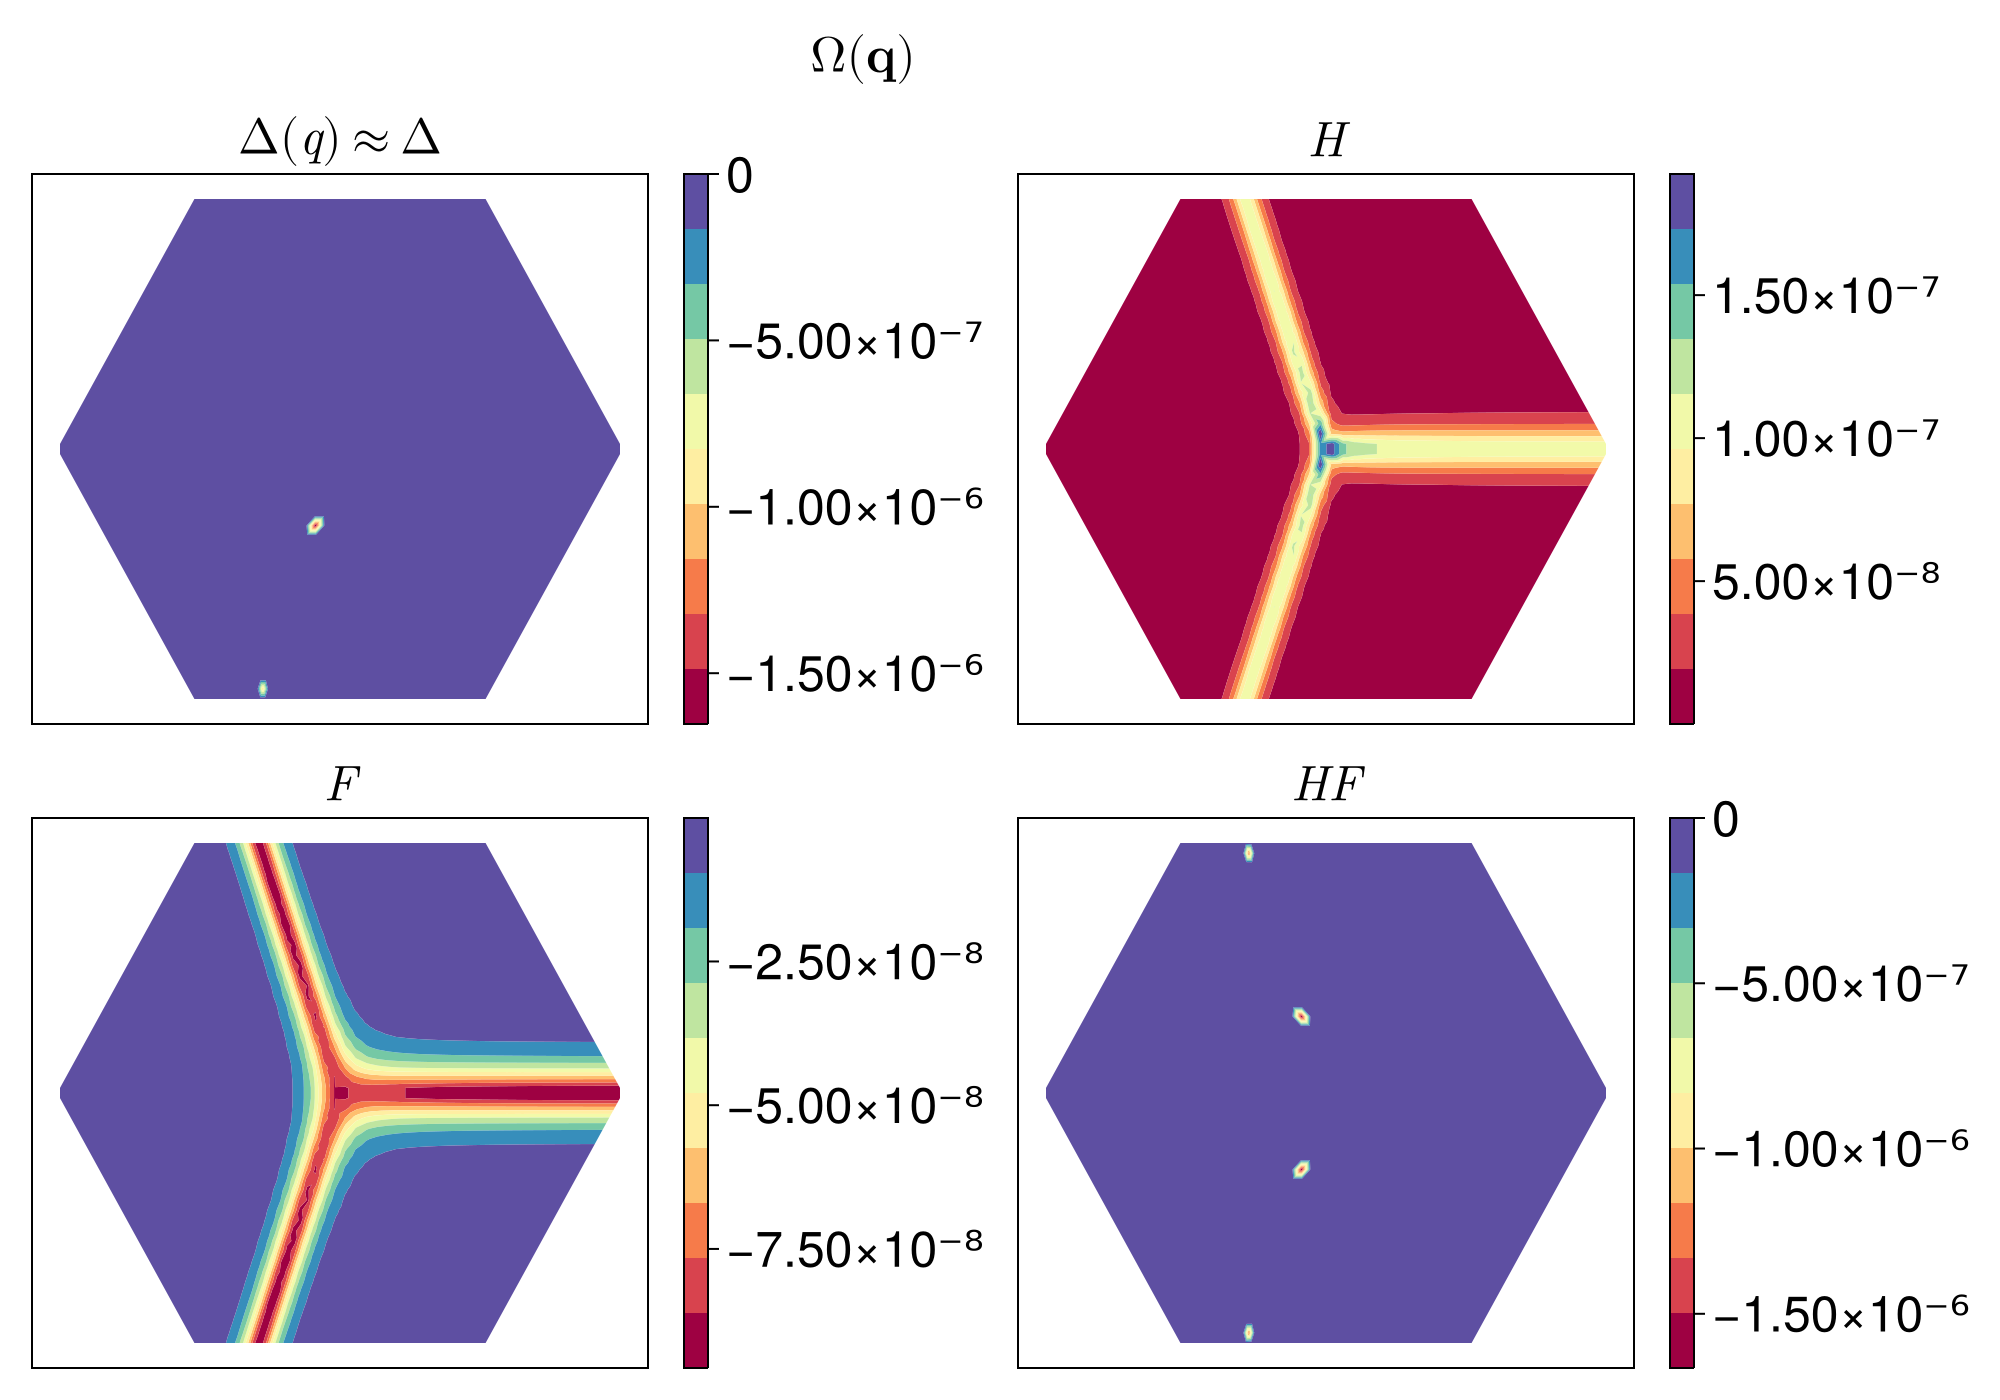

In [384]:
fig = Figure(size=(1000, 700), fontsize=25)
    
ax1 = Axis(fig[1, 1], title = L"\Delta(q) \approx \Delta")
tricontourf!(ax1, grid[:, 1], grid[:, 2], triv_curvature, colormap = :Spectral)
hidedecorations!(ax1)
X, ax1, tr1 = tricontourf(grid[:, 1], grid[:, 2], triv_curvature, colormap = :Spectral)
cb1 = Colorbar(fig[1, 2], tr1)


ax2 = Axis(fig[1, 3], title = L"H")
tricontourf!(ax2, grid[:, 1], grid[:, 2], H_curvature, colormap = :Spectral)
hidedecorations!(ax2)
X, ax2, tr2 = tricontourf(grid[:, 1], grid[:, 2], H_curvature, colormap = :Spectral)
cb2 = Colorbar(fig[1, 4], tr2)

ax3 = Axis(fig[2, 1], title = L"F")
tricontourf!(ax3, grid[:, 1], grid[:, 2], F_curvature, colormap = :Spectral)
hidedecorations!(ax3)
X, ax3, tr3 = tricontourf(grid[:, 1], grid[:, 2], F_curvature, colormap = :Spectral)
cb3 = Colorbar(fig[2, 2], tr3)


ax4 = Axis(fig[2, 3], title = L"HF")
tricontourf!(ax4, grid[:, 1], grid[:, 2], HF_curvature, colormap = :Spectral)
hidedecorations!(ax4)
X, ax4, tr4 = tricontourf(grid[:, 1], grid[:, 2], HF_curvature, colormap = :Spectral)
cb4 = Colorbar(fig[2, 4], tr4)

ax = Axis(fig[:, :], title = L"\Omega (\textbf{q})", titlegap = 45)
hidedecorations!(ax, label = false)
hidespines!(ax)

fig

In [373]:
mom_params = Array{Float64}(undef, pd^2, 2)
for j in 1:pd^2
    mom_params[j, 1] = polar_angle(grid[j, 1], grid[j, 2])
    mom_params[j, 2] = norm(grid[j, :])
end

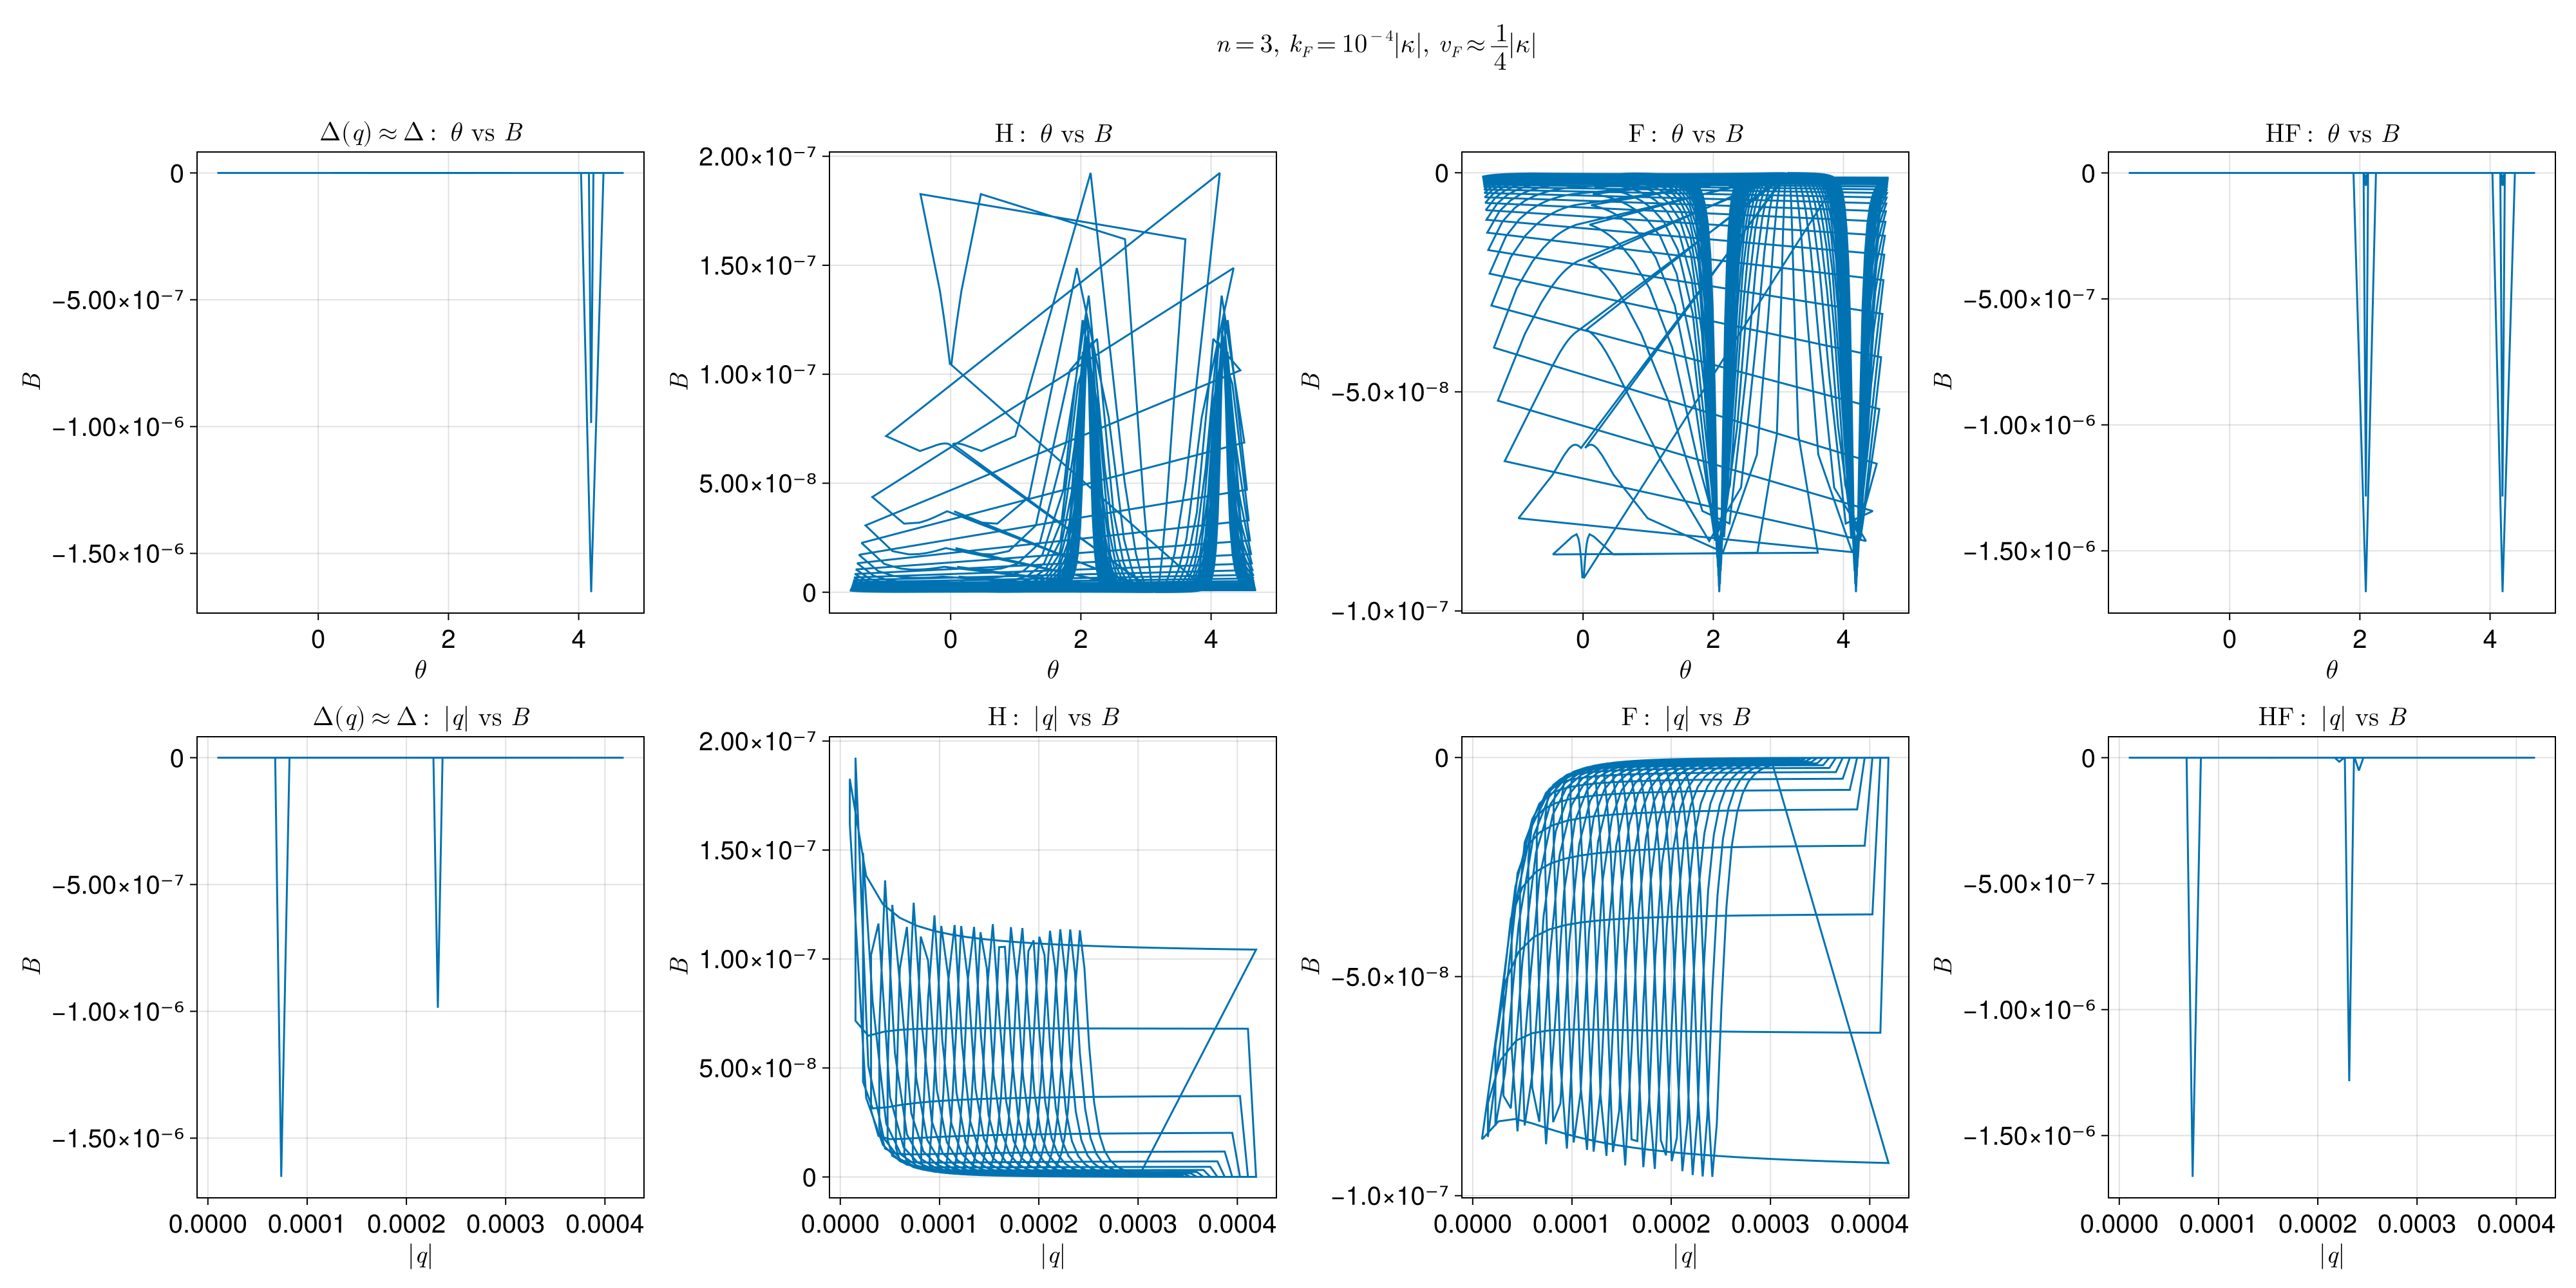

In [374]:
# create plot
P = Figure(size=(2000, 1000), fontsize=20)
# create and configure axes
ax1 = Axis(P[1, 1], title = L"\Delta(q) \approx \Delta \text{: } \theta \text{ vs } B", xlabel = L"\theta", ylabel = L"B")
lines!(ax1, mom_params[:, 1], triv_curvature)

ax2 = Axis(P[2, 1], title = L"\Delta(q) \approx \Delta \text{: } |q| \text{ vs } B", xlabel = L"|q|", ylabel = L"B")
lines!(ax2, mom_params[:, 2], triv_curvature)

ax1 = Axis(P[1, 2], title = L"\text{H: } \theta \text{ vs } B", xlabel = L"\theta", ylabel = L"B")
lines!(ax1, mom_params[:, 1], H_curvature)

ax2 = Axis(P[2, 2], title = L"\text{H: } |q| \text{ vs } B", xlabel = L"|q|", ylabel = L"B")
lines!(ax2, mom_params[:, 2], H_curvature)

ax1 = Axis(P[1, 3], title = L"\text{F: } \theta \text{ vs } B", xlabel = L"\theta", ylabel = L"B")
lines!(ax1, mom_params[:, 1], F_curvature)

ax2 = Axis(P[2, 3], title = L"\text{F: } |q| \text{ vs } B", xlabel = L"|q|", ylabel = L"B")
lines!(ax2, mom_params[:, 2], F_curvature)

ax1 = Axis(P[1, 4], title = L"\text{HF: } \theta \text{ vs } B", xlabel = L"\theta", ylabel = L"B")
lines!(ax1, mom_params[:, 1], HF_curvature)

ax2 = Axis(P[2, 4], title = L"\text{HF: } |q| \text{ vs } B", xlabel = L"|q|", ylabel = L"B")
lines!(ax2, mom_params[:, 2], HF_curvature)

ax = Axis(P[:, :], title = L"n = 3, \ k_F = 10^{-4} |\kappa|, \ v_F \approx \frac{1}{4} |\kappa|", titlegap = 60)
hidedecorations!(ax, label = false)
hidespines!(ax)

P